# <center> A Learnheuristic Approach to A Constrained Multi-Objective Portfolio Optimisation Problem
<center> Sonia Bullah (2107762)
<center> Supervised by Prof. Terence van Zyl and Mr Andrew Paskaramoorthy

The following imported libraries will be used:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import mean_squared_error
import time
import random
import math 

# pip install PyPortfolioOpt  
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import CLA, plotting
import cvxpy as cp
from pypfopt import objective_functions

# pip install plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# pip install pymoo
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.rnsga2 import RNSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.optimize import minimize
from pymoo.factory import get_reference_directions
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.indicators.hv import Hypervolume

# pip install pymoo==0.6.0.dev0
# pip install -U pysamoo
from pysamoo.algorithms.gpsaf import GPSAF

# pip install portfolio-backtest
from portfolio_backtest import Backtest
import pprint

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
# Read in the S&P 500 dataset:
df = pd.read_csv("Dataset/all_stocks_5yr.csv")
df

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


## Data Cleaning And Exploration:

In [3]:
# The current datatypes of the respective columns are stored as:
df.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [4]:
# Convert 'date' to datetime:
df['date'] = pd.to_datetime(df['date'])

# Convert 'Name' to string:
df['Name'] = df['Name'].astype('string')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  string        
dtypes: datetime64[ns](1), float64(4), int64(1), string(1)
memory usage: 33.1 MB


In [5]:
# Create a new dataframe with the closing prices for each stock over 5 years:
df_closingPrices = pd.DataFrame()

# Get a list of all stock names:
stocks = df.Name.unique()

for i in stocks:
    df_closing_price = pd.read_csv('Dataset/individual_stocks_5yr/individual_stocks_5yr/{}_data.csv'.format(i))
    df_closingPrices['{}'.format(i)] = df_closing_price['close']
    
    
df_closingPrices['Date'] = df['date']

# Set the date column as the index column:
df_closingPrices.set_index('Date', inplace=True)

In [6]:
# Identifying duplicates in the dataframe:
duplicated_data = df_closingPrices.duplicated()

duplicated = duplicated_data[duplicated_data == True]
print(duplicated)

Series([], dtype: bool)


As shown above, there are no duplicate values in the dataset.

In [7]:
# Replacing all the zeros with null values to mark them as invalid:
df_closingPrices = df_closingPrices.replace(0, np.nan)

# Identifying number of missing/null values:
invalid_data = df_closingPrices.isna().sum(axis=0)

# Print all columns that contain 1 or more missing/null values:
(invalid_data).sum()

16755

As shown above, there are some missing values as the dataset is that of an index. These values should be dropped from the dataframe as they are invalid entries.

In [8]:
# Create a copy of the dataframe:
copy_prices = df_closingPrices

# Select the columns that contain one or more null values:
cols = np.where((copy_prices.isna().sum(axis=0) > 1))

# Deleting the 35 columns found above:
df_closingPrices = copy_prices.drop(copy_prices.columns[cols],axis = 1)

# The FB stock is not in the backtesting tickers, so we can just drop that column now:
df_closingPrices = df_closingPrices.drop('FB', axis=1)

df_closingPrices

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2013-02-08,14.75,67.8542,78.90,36.25,46.89,34.41,73.31,39.12,45.70,30.22,...,37.51,28.24,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-11,14.46,68.5614,78.39,35.85,46.76,34.26,73.07,38.64,46.08,30.28,...,37.46,28.31,88.28,42.84,31.96,27.46,64.55,75.65,24.21,33.26
2013-02-12,14.27,66.8428,78.60,35.42,46.96,34.30,73.37,38.89,46.27,30.81,...,37.58,28.41,88.46,42.87,31.84,27.95,64.75,75.44,24.49,33.74
2013-02-13,14.66,66.7156,78.97,35.27,46.64,34.46,73.56,38.81,46.26,31.16,...,37.80,28.42,88.67,43.08,32.00,28.26,64.41,76.00,24.74,33.55
2013-02-14,13.99,66.6556,78.84,36.57,46.77,34.70,73.13,38.61,46.54,31.40,...,38.44,28.22,88.52,42.91,32.12,28.47,63.89,76.34,24.63,33.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-01,53.88,167.7800,117.29,116.34,99.29,62.18,160.46,199.38,91.65,42.46,...,72.49,36.79,89.07,60.73,32.75,74.84,83.98,128.19,54.98,77.82
2018-02-02,52.10,160.5000,113.93,115.17,96.02,61.69,156.90,195.64,89.11,41.43,...,70.64,38.25,84.53,60.06,31.63,75.66,82.63,125.79,54.15,76.78
2018-02-05,49.76,156.4900,109.86,109.51,91.90,58.73,151.83,190.27,85.40,40.60,...,66.97,37.68,79.72,58.54,31.38,72.66,79.80,123.18,51.65,73.83


In [9]:
# Dropping invalid entries:
# df_closingPrices.dropna(inplace=True)

# Check to see if all invalid entries have been dropped from the dataframe:
invalid_data = df_closingPrices.isna().sum(axis=0)
(invalid_data).sum()

0

Therefore, it can be seen from above that there are no more invalid entries present in the dataframe.

In [10]:
mu_all_stocks = expected_returns.mean_historical_return(df_closingPrices)
S_all_stocks = risk_models.sample_cov(df_closingPrices)

mu_all_stocks

AAL     0.284123
AAPL    0.186798
AAP     0.068695
ABBV    0.257150
ABC     0.150029
          ...   
XYL     0.215586
YUM     0.041849
ZBH     0.097671
ZION    0.175100
ZTS     0.174786
Length: 469, dtype: float64

In [11]:
# Get top 10 stocks with highest returns:
top_ten = mu_all_stocks.sort_values(ascending=False)
top_ten.head(10)

NVDA    0.793991
NFLX    0.593399
ALGN    0.483366
EA      0.480222
STZ     0.464822
AVGO    0.464697
MU      0.402955
AMZN    0.402329
ATVI    0.390235
HII     0.389895
dtype: float64

In [12]:
listing = list(top_ten.index.values)
print(listing[:10])

['NVDA', 'NFLX', 'ALGN', 'EA', 'STZ', 'AVGO', 'MU', 'AMZN', 'ATVI', 'HII']


In [13]:
df_closing = df_closingPrices[listing[:10]]
df_closing

,NVDA,NFLX,ALGN,EA,STZ,AVGO,MU,AMZN,ATVI,HII
Date,,,,,,,,,,
2013-02-08,12.37,25.8528,32.73,17.37,31.85,35.32,7.75,261.95,13.41,45.39
2013-02-11,12.51,25.4128,33.03,17.41,31.32,35.40,7.91,257.21,13.57,45.23
2013-02-12,12.43,25.4214,33.02,17.54,31.49,35.14,7.92,258.70,13.51,45.25
2013-02-13,12.37,26.6098,32.75,17.17,31.88,35.17,7.95,269.47,13.73,45.55
2013-02-14,12.73,26.7714,32.56,17.15,43.75,35.64,8.08,269.24,14.00,45.20
...,...,...,...,...,...,...,...,...,...,...
2018-02-01,240.50,265.0700,255.57,128.18,220.69,238.79,42.49,1390.00,73.35,241.47
2018-02-02,233.52,267.4300,257.38,124.53,215.89,235.48,40.82,1429.95,71.42,243.77
2018-02-05,213.70,254.2600,242.40,121.64,211.00,228.10,39.40,1390.00,67.98,228.61


In [14]:
df_closing.tail()

,NVDA,NFLX,ALGN,EA,STZ,AVGO,MU,AMZN,ATVI,HII
Date,,,,,,,,,,
2018-02-01,240.50,265.07,255.57,128.18,220.69,238.79,42.49,1390.00,73.35,241.47
2018-02-02,233.52,267.43,257.38,124.53,215.89,235.48,40.82,1429.95,71.42,243.77
2018-02-05,213.70,254.26,242.40,121.64,211.00,228.10,39.40,1390.00,67.98,228.61
2018-02-06,225.58,265.72,241.45,123.13,216.29,240.38,43.88,1442.84,69.70,227.67
2018-02-07,228.80,264.56,234.33,123.05,214.15,237.38,42.01,1416.78,69.46,234.82


## Forecasting:

In order to forecast the data, some for of noise needs to be added. This noise represents an error that will increase or decrease predictions. In essence, this will make it difficult to make accurate predictions. Adding noise to the data can be done as follows:

In [15]:
mean = 0
std_dev = 0.1
noise = np.random.normal(mean, std_dev, df_closing.shape) 

print(noise)

[[-2.12067719e-01 -5.59814660e-02  1.61897944e-01 ... -5.97322467e-03
   3.40716019e-02  1.24358473e-04]
 [ 9.00994455e-02 -1.64809992e-01 -1.24356547e-01 ...  2.01104300e-01
   3.18073679e-02  2.70762780e-01]
 [-6.00748957e-03 -6.79371019e-02 -1.08471064e-01 ... -8.46697264e-02
  -6.05053149e-02 -8.16360577e-02]
 ...
 [ 1.03448587e-02  1.32405537e-01  5.35308278e-02 ...  7.86565209e-02
   2.45318566e-01  1.49707225e-01]
 [-2.44470696e-02 -1.70487608e-02  4.28838764e-02 ... -2.66296088e-02
  -1.03990698e-01  1.53329300e-01]
 [ 8.73677644e-02 -6.06757286e-02 -1.43173539e-01 ... -6.16553679e-02
   6.52783646e-02  2.02399128e-02]]


In [16]:
# Dataframe before forecasting:
df_closing.head()

,NVDA,NFLX,ALGN,EA,STZ,AVGO,MU,AMZN,ATVI,HII
Date,,,,,,,,,,
2013-02-08,12.37,25.8528,32.73,17.37,31.85,35.32,7.75,261.95,13.41,45.39
2013-02-11,12.51,25.4128,33.03,17.41,31.32,35.40,7.91,257.21,13.57,45.23
2013-02-12,12.43,25.4214,33.02,17.54,31.49,35.14,7.92,258.70,13.51,45.25
2013-02-13,12.37,26.6098,32.75,17.17,31.88,35.17,7.95,269.47,13.73,45.55
2013-02-14,12.73,26.7714,32.56,17.15,43.75,35.64,8.08,269.24,14.00,45.20


In [17]:
# Dataframe after forecasting:
forecasted_data = df_closing + noise

forecasted_data

,NVDA,NFLX,ALGN,EA,STZ,AVGO,MU,AMZN,ATVI,HII
Date,,,,,,,,,,
2013-02-08,12.157932,25.796819,32.891898,17.409744,31.570877,35.344647,7.802001,261.944027,13.444072,45.390124
2013-02-11,12.600099,25.247990,32.905643,17.534516,31.453004,35.321293,7.812058,257.411104,13.601807,45.500763
2013-02-12,12.423993,25.353463,32.911529,17.514383,31.545716,34.990064,7.994977,258.615330,13.449495,45.168364
2013-02-13,12.174219,26.727944,32.751744,17.039166,31.766331,35.234586,8.004804,269.463888,13.803969,45.418716
2013-02-14,12.769776,26.661804,32.504164,17.042693,43.828838,35.492429,8.139000,269.119960,14.043351,45.265022
...,...,...,...,...,...,...,...,...,...,...
2018-02-01,240.440385,265.101992,255.599815,128.102691,220.579028,238.654450,42.374364,1390.075895,73.051422,241.534613
2018-02-02,233.448025,267.474202,257.297360,124.617693,215.829549,235.286172,40.963210,1430.084600,71.310892,243.678521
2018-02-05,213.710345,254.392406,242.453531,121.539610,210.818516,227.898940,39.377372,1390.078657,68.225319,228.759707


In [18]:
# Dropping invalid entries:
forecasted_data.dropna(inplace=True)

# Check to see if all invalid entries have been dropped from the dataframe:
forecasted_data

,NVDA,NFLX,ALGN,EA,STZ,AVGO,MU,AMZN,ATVI,HII
Date,,,,,,,,,,
2013-02-08,12.157932,25.796819,32.891898,17.409744,31.570877,35.344647,7.802001,261.944027,13.444072,45.390124
2013-02-11,12.600099,25.247990,32.905643,17.534516,31.453004,35.321293,7.812058,257.411104,13.601807,45.500763
2013-02-12,12.423993,25.353463,32.911529,17.514383,31.545716,34.990064,7.994977,258.615330,13.449495,45.168364
2013-02-13,12.174219,26.727944,32.751744,17.039166,31.766331,35.234586,8.004804,269.463888,13.803969,45.418716
2013-02-14,12.769776,26.661804,32.504164,17.042693,43.828838,35.492429,8.139000,269.119960,14.043351,45.265022
...,...,...,...,...,...,...,...,...,...,...
2018-02-01,240.440385,265.101992,255.599815,128.102691,220.579028,238.654450,42.374364,1390.075895,73.051422,241.534613
2018-02-02,233.448025,267.474202,257.297360,124.617693,215.829549,235.286172,40.963210,1430.084600,71.310892,243.678521
2018-02-05,213.710345,254.392406,242.453531,121.539610,210.818516,227.898940,39.377372,1390.078657,68.225319,228.759707


As shown above, the data has been successfully forecased.

## Portfolio Optimisation:

In [19]:
returns = expected_returns.capm_return(forecasted_data)
sample_covariance = risk_models.CovarianceShrinkage(forecasted_data).ledoit_wolf()

returns

NVDA    0.634850
NFLX    0.697598
ALGN    0.507314
EA      0.510285
STZ     0.331986
AVGO    0.595647
MU      0.782777
AMZN    0.478174
ATVI    0.529212
HII     0.329311
Name: mkt, dtype: float64

In [20]:
# Critical Line Algorithm:
cla = CLA(returns, sample_covariance)
cla.max_sharpe()
cla.portfolio_performance(verbose=True);

Expected annual return: 53.6%
Annual volatility: 18.8%
Sharpe Ratio: 2.74


Text(0.5, 1.0, 'Efficient Frontier - Unconstrained Portfolio')

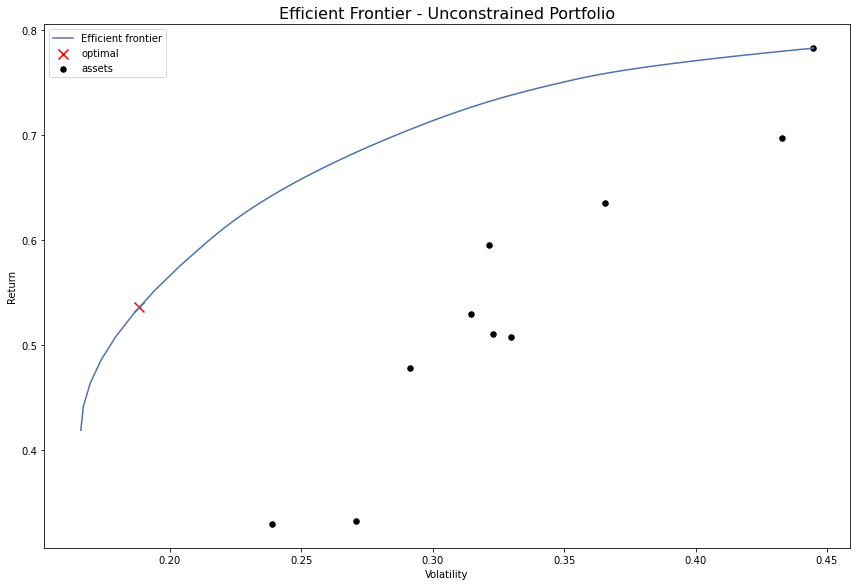

In [21]:
plt.figure(figsize=(12,8))
ax = plotting.plot_efficient_frontier(cla, showfig=False)
ax.set_title('Efficient Frontier - Unconstrained Portfolio', fontsize=16)

Now, we can add a constraint to the optimisation problem. Adding an arbitrary constraint that uses a value of 0.2 will produce the following efficient frontier:

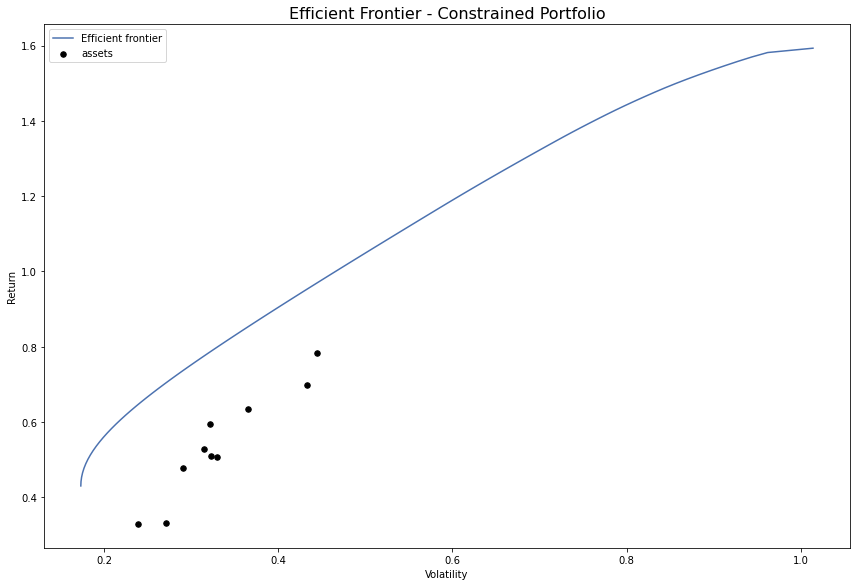

In [22]:
returns = expected_returns.capm_return(forecasted_data)
sample_covariance = risk_models.CovarianceShrinkage(forecasted_data).ledoit_wolf()

eff_frontier = EfficientFrontier(returns, sample_covariance, weight_bounds=(None, None))
eff_frontier.add_constraint(lambda w: w[0] >= 0.2)

fig, ax = plt.subplots(figsize=(12,8))
plotting.plot_efficient_frontier(eff_frontier, ax=ax, show_assets=True)
ax.set_title('Efficient Frontier - Constrained Portfolio', fontsize=16)
plt.show()

However, 0.2 is just a random constraint value. We need to search for the best possible constraint parameter so that we do not need to use arbitrary values. To do this, we will use 4 various genetic algorithms and plot the results found.

## Genetic Algorithms:

In [23]:
class ProblemWrapper(Problem):
    
    def __init__(self):
        super().__init__(n_var=1,
                         n_obj=3,
                         xl=np.array([0]),
                         xu=np.array([1]))
    
    def _evaluate(self, x, out, *args, **kwargs):
        res = []
        
        for i in x:

            eff_frontier = EfficientFrontier(exp_returns, covariance, weight_bounds=(None, None))
            eff_frontier.add_constraint(lambda costs: costs[0] <= i)
            eff_frontier.max_sharpe()
            
            res.append(eff_frontier.portfolio_performance(verbose=False))
            
            
        out['F'] = np.array(res)

In [24]:
class ProblemWrapper_Weights(Problem):
    
    def __init__(self):
        super().__init__(n_var=1,
                         n_obj=10,
                         xl=np.array([0]),
                         xu=np.array([1]))
    
    def _evaluate(self, x, out, *args, **kwargs):
        results = []
        
        for i in x:

            eff_frontier = EfficientFrontier(exp_returns, covariance)
            eff_frontier.add_objective(objective_functions.L2_reg, gamma=i)
            raw_weights = eff_frontier.max_sharpe()
            
            weight_array = []
            for key, value in raw_weights.items():
                
                # Adding weights of assets to an array in the following order:
                # NVDA, NFLX, ALGN, EA, STZ, AVGO, FB, MU, AMZN, ATVI
                weight_array.append(value)
  
            results.append(weight_array) 
            
        out['F'] = np.array(results)

In [25]:
def plot_genetic_algos(results1, results2, results3, results4, algorithm):
    
    
    fig = make_subplots()
    
    # Get the transpose of the array above so that all x values are in one array and all y values 
    # are in another array:
    results1_t = results1.T
    results2_t = results2.T
    results3_t = results3.T
    results4_t = results4.T

    # Plotting:
    # Remember to take the negative of the returns.

   # Adding traces:
    fig.add_trace(
    go.Scatter(x=results1_t[1], y=(results1_t[0]*-1),  name="NSGA_II", mode='markers')
    )

    fig.add_trace(
        go.Scatter(x=results2_t[1], y=(results2_t[0]*-1),  name="R_NSGA_II", mode='markers')
    )
    
    fig.add_trace(
        go.Scatter(x=results3_t[1], y=(results3_t[0]*-1),  name="NSGA_III", mode='markers')
    )
    
    fig.add_trace(
        go.Scatter(x=results4_t[1], y=(results4_t[0]*-1),  name="U_NSGA_III", mode='markers')
    )

    fig.update_layout(

        title={'text': "Pareto Frontier for A Constrained Portfolio: {}".format(algorithm), 
               'y':0.9,
               'x':0.5,
               'xanchor': 'center',
               'yanchor': 'top'},

        xaxis_title="Volatility",
        yaxis_title="Return",)

    fig.show()

### NSGA-II:

In [26]:
def NSGA2_Algorithm(population, generation, objective, algorithm_type, run_number):
    
    # Create the problem based on whether the objective is to find a value for the constraint or to find the 
    # optimal set of weights for each stock:
    if(objective == 'constraint'):
        problem = ProblemWrapper()
        
    else:
        problem = ProblemWrapper_Weights()

    offsprings = [2, 3, 2, 3, 3, 3, 3, 3, 3, 3]
    genetic_algorithm = NSGA2(pop_size=population, n_offsprings=offsprings[run_number])
    
    num = [15, 1, 2, 7, 10, 13, 14, 17, 20, 21]
    surrogate_assisted_algorithm = GPSAF(genetic_algorithm,
                                         alpha=num[run_number],
                                         beta=num[run_number] * 5,
                                         n_max_doe=num[run_number] * 10,
                                         n_max_infills=np.inf)


    # Start timer:
    start_time = time.time()
    
    # Begin optimisation:
    random_seed = random.randint(1, 50)
    seed = [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
        
    if(algorithm_type == 'baseline'):
        result = minimize(problem,
                       genetic_algorithm,
                       ('n_gen', generation),
                       seed=random_seed,
                       save_history=True,
                       verbose=True)
        
    else:
        result = minimize(problem,
                       surrogate_assisted_algorithm,
                       ('n_gen', generation),
                       seed=seed[run_number],
                       save_history=True,
                       verbose=True)

    # End timer:
    end_time = time.time()

    # Removing the Sharpe Ratio values from each array as we do not want a 3D plot
    array = result.F
    NSGA_II_results = np.delete(array, 2, axis=1)
    
    time_taken = round(end_time - start_time, 4)

    print("\n")
    print("Time Taken for Algorithm To Run: ", time_taken , "seconds")
    print("\n")
        
    return NSGA_II_results, result, time_taken

### R-NSGA-II:

In [27]:
def R_NSGA2_Algorithm(population, generation, objective, algorithm_type, run_number):

    # Create the problem based on whether the objective is to find a value for the constraint or to find the 
    # optimal set of weights for each stock:
    if(objective == 'constraint'):
        # Define reference points
        reference_points = np.array([[0.5, 0.2, 0.1], [0.1, 0.6, 0.2]])
        problem = ProblemWrapper()
        w = np.array([0.5, 0.5, 0.5])
        
    else:
        # Define reference points
        reference_points = np.array([[0.5, 0.2, 0.1, 0.5, 0.2, 0.1, 0.5, 0.2, 0.1, 0.1], 
                                     [0.1, 0.6, 0.2, 0.1, 0.6, 0.2, 0.1, 0.6, 0.2, 0.1]])
        problem = ProblemWrapper_Weights()
        w = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
        
    pareto_front = problem.pareto_front()

    # Get Algorithm:
    genetic_algorithm = RNSGA2(
        ref_points=reference_points,
        pop_size=population,
        n_offsprings=2,
        epsilon=0.01,
        normalization='front',
        extreme_points_as_reference_points=False,
        weights=w)

    num = [15, 1, 5, 9, 16, 2, 13, 14, 16, 20]
    surrogate_assisted_algorithm = GPSAF(genetic_algorithm,
                                         alpha=num[run_number],
                                         beta=num[run_number] * 5,
                                         n_max_doe=num[run_number] * 10,
                                         n_max_infills=np.inf)


     # Start timer:
    start_time = time.time()
    
    # Begin optimisation:
    random_seed = random.randint(1, 50)
    seed = [7, 7, 7, 7, 7, 8, 8, 8, 8, 8]
    
    if(algorithm_type == 'baseline'):
        result = minimize(problem,
                       genetic_algorithm,
                       save_history=True,
                       termination=('n_gen', generation),
                       seed=random_seed,
                       pf=pareto_front,
                       disp=True,
                       verbose=True)
        
    elif(algorithm_type == 'surrogate'):
        result = minimize(problem,
                       surrogate_assisted_algorithm,
                       save_history=True,
                       termination=('n_gen', generation),
                       seed=seed[run_number],
                       pf=pareto_front,
                       disp=True,
                       verbose=True)
    
    # End timer:
    end_time = time.time()
    
    # Removing the Sharpe Ratio values from each array as we do not want a 3D plot
    array = result.F
    R_NSGA_II_results = np.delete(array, 2, axis=1)
    
    time_taken = round(end_time - start_time, 4)

    print("\n")
    print("Time Taken for Algorithm To Run: ", time_taken , "seconds")
    print("\n")
        
    return R_NSGA_II_results, result, time_taken

### NSGA-III:

In [28]:
def NSGA3_Algorithm(population, generation, objective, algorithm_type, run_number):
    # create the reference directions to be used for the optimization
    reference_direction = get_reference_directions("das-dennis", 3, n_partitions=2)

    # Create the problem based on whether the objective is to find a value for the constraint or to find the 
    # optimal set of weights for each stock:
    if(objective == 'constraint'):
        reference_direction = get_reference_directions("das-dennis", 3, n_partitions=2)
        problem = ProblemWrapper()
        
    else:
        reference_direction = get_reference_directions("das-dennis", 10, n_partitions=1)
        problem = ProblemWrapper_Weights()

    genetic_algorithm = NSGA3(pop_size=population,
                              n_offsprings=2,
                              ref_dirs=reference_direction)
    
    num = [2, 1, 7, 13, 14, 16, 17, 18, 19, 25]
    surrogate_assisted_algorithm = GPSAF(genetic_algorithm,
                                         alpha=num[run_number],
                                         beta=num[run_number] * 5,
                                         n_max_doe=num[run_number] * 10,
                                         n_max_infills=np.inf)

    # Start timer:
    start_time = time.time()
    
    # Begin optimisation:
    random_seed = random.randint(1, 50)
    
    if(algorithm_type == 'baseline'):
        result = minimize(problem,
                       genetic_algorithm,
                       seed=random_seed,
                       save_history=True,
                       termination=('n_gen', generation),
                       verbose=True)
        
    elif(algorithm_type == 'surrogate'):
        result = minimize(problem,
                       surrogate_assisted_algorithm,
                       seed=8,
                       save_history=True,
                       termination=('n_gen', generation),
                       verbose=True)

    # End timer:
    end_time = time.time()
        
    # Removing the Sharpe Ratio values from each array as we do not want a 3D plot
    array = result.F
    NSGA_III_results = np.delete(array, 2, axis=1)
    
    time_taken = round(end_time - start_time, 4)

    print("\n")
    print("Time Taken for Algorithm To Run: ", time_taken , "seconds")
    print("\n")
        
    return NSGA_III_results, result, time_taken

### U-NSGA-III:

In [29]:
def U_NSGA3_Algorithm(population, generation, objective, algorithm_type, run_number):
    # create the reference directions to be used for the optimization - just a single one here

    # Create the problem based on whether the objective is to find a value for the constraint or to find the 
    # optimal set of weights for each stock:
    if(objective == 'constraint'):
        reference_direction = get_reference_directions("energy", 3, 10, seed=1)
        problem = ProblemWrapper()
        
    else:
        reference_direction = get_reference_directions("energy", 10, 10, seed=1)
        problem = ProblemWrapper_Weights()

    genetic_algorithm = UNSGA3(reference_direction, pop_size=population, n_offsprings=2)
    

    num = [1, 7, 10, 13, 14, 16, 17, 18, 15, 24]
    surrogate_assisted_algorithm = GPSAF(genetic_algorithm,
                                         alpha=num[run_number],
                                         beta=num[run_number] * 5,
                                         n_max_doe=num[run_number] * 10,
                                         n_max_infills=np.inf)

    # Start timer:
    start_time = time.time()
    
    # Begin optimisation:
    random_seed = random.randint(1, 50)
    
    if(algorithm_type == 'baseline'):
        result = minimize(problem,
                       genetic_algorithm,
                       termination=('n_gen', generation),
                       save_history=True,
                       seed=random_seed,
                       verbose=True)
        
    elif(algorithm_type == 'surrogate'):
        result = minimize(problem,
                       surrogate_assisted_algorithm,
                       termination=('n_gen', generation),
                       save_history=True,
                       seed=8,
                       verbose=True)
    
    # End timer:
    end_time = time.time()
    
    # Removing the Sharpe Ratio values from each array as we do not want a 3D plot
    array = result.F
    U_NSGA_III_results = np.delete(array, 2, axis=1)
    
    time_taken = round(end_time - start_time, 4)

    print("\n")
    print("Time Taken for Algorithm To Run: ", time_taken , "seconds")
    print("\n")
        
    return U_NSGA_III_results, result, time_taken

We can now run all four algorithms, change parameters and compare results.

In [30]:
exp_returns = expected_returns.capm_return(forecasted_data)
covariance = risk_models.CovarianceShrinkage(df_closing).ledoit_wolf()

runs = 0

NSGA_II_results = ['NSGA_II_results1', 'NSGA_II_results2', 'NSGA_II_results3', 'NSGA_II_results4', 
                        'NSGA_II_results5', 'NSGA_II_results6', 'NSGA_II_results7', 'NSGA_II_results8', 
                        'NSGA_II_results9', 'NSGA_II_results10']
NSGA2result = ['NSGA2result1', 'NSGA2result2', 'NSGA2result3', 'NSGA2result4', 'NSGA2result5', 'NSGA2result6', 
               'NSGA2result7', 'NSGA2result8', 'NSGA2result9', 'NSGA2result10']

R_NSGA_II_results = ['R_NSGA_II_results1', 'R_NSGA_II_results2', 'R_NSGA_II_results3', 'R_NSGA_II_results4', 
                     'R_NSGA_II_results5', 'R_NSGA_II_results6', 'R_NSGA_II_results7', 'R_NSGA_II_results8', 
                     'R_NSGA_II_results9', 'R_NSGA_II_results10']
RNSGA2result = ['RNSGA2result1', 'RNSGA2result2', 'RNSGA2result3', 'RNSGA2result4', 'RNSGA2result5', 
                'RNSGA2result6', 'RNSGA2result7', 'RNSGA2result8', 'RNSGA2result9', 'RNSGA2result10']

NSGA_III_results = ['NSGA_III_results1', 'NSGA_III_results2', 'NSGA_III_results3', 'NSGA_III_results4', 
                    'NSGA_III_results5', 'NSGA_III_results6', 'NSGA_III_results7', 'NSGA_III_results8', 
                    'NSGA_III_results9', 'NSGA_III_results10']
NSGA3result = ['NSGA3result1', 'NSGA3result2', 'NSGA3result3', 'NSGA3result4', 'NSGA3result5', 
                'NSGA3result6', 'NSGA3result7', 'NSGA3result8', 'NSGA3result9', 'NSGA3result10']

U_NSGA_III_results = ['U_NSGA_III_results1', 'U_NSGA_III_results2', 'U_NSGA_III_results3', 'U_NSGA_III_results4', 
                      'U_NSGA_III_results5', 'U_NSGA_III_results6', 'U_NSGA_III_results7', 'U_NSGA_III_results8', 
                      'U_NSGA_III_results9', 'U_NSGA_III_results10']
UNSGA3result = ['UNSGA3result1', 'UNSGA3result2', 'UNSGA3result3', 'UNSGA3result4', 'UNSGA3result5', 
                'UNSGA3result6', 'UNSGA3result7', 'UNSGA3result8', 'UNSGA3result9', 'UNSGA3result10']

NSGA2_time = ['time1', 'time2', 'time3', 'time4', 'time5', 'time6', 'time7', 'time8', 'time9', 'time10']
RNSGA2_time = ['time1', 'time2', 'time3', 'time4', 'time5', 'time6', 'time7', 'time8', 'time9', 'time10']
NSGA3_time = ['time1', 'time2', 'time3', 'time4', 'time5', 'time6', 'time7', 'time8', 'time9', 'time10']
UNSGA3_time = ['time1', 'time2', 'time3', 'time4', 'time5', 'time6', 'time7', 'time8', 'time9', 'time10']


while(runs != 10):
    
    runs = runs + 1

    print("NSGA-II Run ",runs, "- Generations: 30, Population: 12")
    NSGA_II_results[runs-1], NSGA2result[runs-1], NSGA2_time[runs-1] = NSGA2_Algorithm(12, 30, 'constraint', 'baseline', runs-1)

    print("R-NSGA-II Run ",runs, " - Generations: 30, Population: 12")
    R_NSGA_II_results[runs-1], RNSGA2result[runs-1], RNSGA2_time[runs-1] = R_NSGA2_Algorithm(12, 30, 'constraint', 'baseline', runs-1)

    print("NSGA-III Run ",runs, " - Generations: 30, Population: 12")
    NSGA_III_results[runs-1], NSGA3result[runs-1], NSGA3_time[runs-1] = NSGA3_Algorithm(12, 30, 'constraint', 'baseline', runs-1)

    print("U-NSGA-III Run ",runs, " - Generations: 30, Population: 12")
    U_NSGA_III_results[runs-1], UNSGA3result[runs-1], UNSGA3_time[runs-1] = U_NSGA3_Algorithm(12, 30, 'constraint', 'baseline', runs-1)

    
print("Average time taken for each algorithm to run:")

NSGA2_Avg = round(sum(NSGA2_time) / 10, 4)
RNSGA2_Avg = round(sum(RNSGA2_time) / 10, 4)
NSGA3_Avg = round(sum(NSGA3_time) / 10, 4)
UNSGA3_Avg = round(sum(UNSGA3_time) / 10, 4)

print("NSGA-II: ", NSGA2_Avg, "seconds")
print("R-NSGA-II: ", RNSGA2_Avg, "seconds")
print("NSGA-III: ", NSGA3_Avg, "seconds")
print("U-NSGA-III: ", UNSGA3_Avg, "seconds")

NSGA-II Run  1 - Generations: 30, Population: 12
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      12 |       2 |            - |            -
    2 |      14 |       2 |  0.00000E+00 |            f
    3 |      16 |       3 |  0.726918181 |        ideal
    4 |      18 |       3 |  0.00000E+00 |            f
    5 |      20 |       3 |  0.00000E+00 |            f
    6 |      22 |       4 |  0.038242846 |        ideal
    7 |      24 |       4 |  0.00000E+00 |            f
    8 |      26 |       5 |  0.014791821 |            f
    9 |      28 |       5 |  0.00000E+00 |            f
   10 |      30 |       7 |  0.046473858 |            f
   11 |      32 |       7 |  0.00000E+00 |            f
   12 |      34 |       8 |  0.007924561 |            f
   13 |      36 |      10 |  0.002682760 |            f
   14 |      38 |      11 |  0.003849668 |            f
   15 |      40 |      12 |  0.007942184 |            f
   16 |      42 |      12 |  0.001749617 |            f

    8 |      33 |      12 |  0.004332137 |            f
    9 |      36 |      12 |  0.008701576 |            f
   10 |      39 |      12 |  0.004897481 |            f
   11 |      42 |      12 |  0.012640568 |            f
   12 |      45 |      12 |  0.004024842 |            f
   13 |      48 |      12 |  0.004500282 |            f
   14 |      51 |      12 |  0.004063825 |            f
   15 |      54 |      12 |  0.007547113 |            f
   16 |      57 |      12 |  0.005592211 |            f
   17 |      60 |      12 |  0.015759779 |            f
   18 |      63 |      12 |  0.015002148 |            f
   19 |      66 |      12 |  0.007028570 |            f
   20 |      69 |      12 |  0.010690583 |            f
   21 |      72 |      12 |  0.009966524 |            f
   22 |      75 |      12 |  0.002781733 |        ideal
   23 |      78 |      12 |  0.023518360 |        nadir
   24 |      81 |      12 |  0.000036649 |            f
   25 |      84 |      12 |  0.004064395 |      

   16 |      42 |       9 |  0.000239697 |            f
   17 |      44 |      10 |  0.004820862 |            f
   18 |      46 |      12 |  0.006281642 |            f
   19 |      48 |      12 |  0.006678903 |            f
   20 |      50 |      12 |  0.079348023 |            f
   21 |      52 |      12 |  0.010706953 |            f
   22 |      54 |      12 |  0.009232905 |            f
   23 |      56 |      12 |  0.002953803 |            f
   24 |      58 |      12 |  0.013339916 |            f
   25 |      60 |      12 |  0.005732231 |            f
   26 |      62 |      12 |  0.00000E+00 |            f
   27 |      64 |      12 |  0.000246031 |            f
   28 |      66 |      12 |  0.008642494 |            f
   29 |      68 |      12 |  0.004199252 |            f
   30 |      70 |      12 |  0.00000E+00 |            f


Time Taken for Algorithm To Run:  0.8266 seconds


R-NSGA-II Run  3  - Generations: 30, Population: 12
n_gen |  n_eval |  n_nds  |     eps      |  indicator  

   26 |      87 |      12 |  0.007847694 |            f
   27 |      90 |      12 |  0.006373226 |            f
   28 |      93 |      12 |  0.004344179 |            f
   29 |      96 |      12 |  0.005958440 |            f
   30 |      99 |      12 |  0.009352153 |            f


Time Taken for Algorithm To Run:  1.0105 seconds


R-NSGA-II Run  4  - Generations: 30, Population: 12
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      12 |      12 |            - |            -
    2 |      14 |       2 |  0.855663782 |        ideal
    3 |      16 |       3 |  0.314022716 |            f
    4 |      18 |       3 |  0.00000E+00 |            f
    5 |      20 |       4 |  0.001596496 |            f
    6 |      22 |       4 |  0.00000E+00 |            f
    7 |      24 |       4 |  0.00000E+00 |            f
    8 |      26 |       5 |  0.051949543 |            f
    9 |      28 |       5 |  0.141827100 |        ideal
   10 |      30 |       6 |  0.222196566 |        ideal

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      12 |       1 |            - |            -
    2 |      14 |       2 |  1.000000000 |        ideal
    3 |      16 |       2 |  0.00000E+00 |            f
    4 |      18 |       3 |  0.062489556 |        ideal
    5 |      20 |       4 |  0.537152110 |        ideal
    6 |      22 |       4 |  0.006953031 |        ideal
    7 |      24 |       6 |  0.234014580 |        ideal
    8 |      26 |       6 |  0.00000E+00 |            f
    9 |      28 |       8 |  0.034769376 |            f
   10 |      30 |       9 |  0.016561341 |            f
   11 |      32 |      10 |  0.003053228 |            f
   12 |      34 |      11 |  0.006836016 |            f
   13 |      36 |      12 |  0.024275935 |        ideal
   14 |      38 |      12 |  0.319095100 |        ideal
   15 |      40 |      12 |  0.415949686 |        ideal
   16 |      42 |      12 |  0.014312337 |        ideal
   17 |      44 |      12 |  0.021434148 |      

   11 |      32 |       6 |  0.00000E+00 |            f
   12 |      34 |       7 |  0.024267816 |            f
   13 |      36 |       7 |  0.00000E+00 |            f
   14 |      38 |       8 |  0.087840562 |        ideal
   15 |      40 |       8 |  0.00000E+00 |            f
   16 |      42 |       9 |  0.532576511 |        ideal
   17 |      44 |      10 |  0.006343604 |            f
   18 |      46 |      11 |  0.027513261 |            f
   19 |      48 |      12 |  0.022851201 |            f
   20 |      50 |      12 |  0.031009549 |        ideal
   21 |      52 |      12 |  0.105027874 |        ideal
   22 |      54 |      12 |  0.123606996 |        ideal
   23 |      56 |      12 |  0.086947242 |        ideal
   24 |      58 |      12 |  0.298097920 |        ideal
   25 |      60 |      12 |  0.053995885 |        ideal
   26 |      62 |      12 |  0.361742416 |        ideal
   27 |      64 |      12 |  0.221813430 |        ideal
   28 |      66 |      12 |  0.000856728 |      

   18 |      46 |       3 |  0.00000E+00 |            f
   19 |      48 |       4 |  0.024465385 |            f
   20 |      50 |       4 |  0.00000E+00 |            f
   21 |      52 |       5 |  0.538346695 |        ideal
   22 |      54 |       6 |  0.051451209 |            f
   23 |      56 |       7 |  0.020451290 |            f
   24 |      58 |       8 |  0.360882511 |        ideal
   25 |      60 |      10 |  0.007333367 |            f
   26 |      62 |      12 |  0.086020653 |        ideal
   27 |      64 |      12 |  0.008403851 |            f
   28 |      66 |      12 |  0.006182662 |        ideal
   29 |      68 |      12 |  0.113511932 |        ideal
   30 |      70 |      12 |  0.100986366 |        ideal


Time Taken for Algorithm To Run:  0.9044 seconds


NSGA-III Run  7  - Generations: 30, Population: 12
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      12 |       1 |            - |            -
    2 |      14 |       1 |  0.00000E+00 |            f


   30 |      70 |      12 |  0.538740594 |        ideal


Time Taken for Algorithm To Run:  0.7593 seconds


NSGA-III Run  8  - Generations: 30, Population: 12
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      12 |       1 |            - |            -
    2 |      14 |       1 |  0.00000E+00 |            f
    3 |      16 |       1 |  0.024966606 |        ideal
    4 |      18 |       1 |  0.00000E+00 |            f
    5 |      20 |       2 |  1.000000000 |        ideal
    6 |      22 |       2 |  0.00000E+00 |            f
    7 |      24 |       2 |  0.00000E+00 |            f
    8 |      26 |       3 |  0.179522305 |            f
    9 |      28 |       3 |  0.00000E+00 |            f
   10 |      30 |       3 |  0.00000E+00 |            f
   11 |      32 |       3 |  0.00000E+00 |            f
   12 |      34 |       3 |  0.00000E+00 |            f
   13 |      36 |       3 |  0.00000E+00 |            f
   14 |      38 |       3 |  0.00000E+00 |            f


   11 |      32 |       2 |  1.000000000 |        ideal
   12 |      34 |       2 |  0.00000E+00 |            f
   13 |      36 |       2 |  0.00000E+00 |            f
   14 |      38 |       2 |  0.00000E+00 |            f
   15 |      40 |       3 |  0.234291605 |            f
   16 |      42 |       3 |  0.00000E+00 |            f
   17 |      44 |       3 |  0.00000E+00 |            f
   18 |      46 |       3 |  0.00000E+00 |            f
   19 |      48 |       2 |  0.345583335 |        ideal
   20 |      50 |       3 |  0.256827894 |        ideal
   21 |      52 |       2 |  0.753176927 |        ideal
   22 |      54 |       3 |  0.456711243 |        ideal
   23 |      56 |       3 |  0.00000E+00 |            f
   24 |      58 |       4 |  0.102246451 |            f
   25 |      60 |       3 |  0.00000E+00 |            f
   26 |      62 |       4 |  0.102246451 |            f
   27 |      64 |       3 |  0.021162863 |        ideal
   28 |      66 |       4 |  0.103002680 |      

   21 |      52 |       2 |  0.00000E+00 |            f
   22 |      54 |       3 |  0.207331967 |            f
   23 |      56 |       3 |  0.00000E+00 |            f
   24 |      58 |       3 |  1.297220762 |        nadir
   25 |      60 |       3 |  0.022662805 |        ideal
   26 |      62 |       3 |  0.00000E+00 |            f
   27 |      64 |       4 |  0.136232341 |            f
   28 |      66 |       3 |  0.00000E+00 |            f
   29 |      68 |       4 |  0.177253384 |            f
   30 |      70 |       4 |  0.00000E+00 |            f


Time Taken for Algorithm To Run:  0.7544 seconds


U-NSGA-III Run  10  - Generations: 30, Population: 12
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      12 |       2 |            - |            -
    2 |      14 |       2 |  0.00000E+00 |            f
    3 |      16 |       2 |  0.00000E+00 |            f
    4 |      18 |       2 |  0.00000E+00 |            f
    5 |      20 |       2 |  0.00000E+00 |           

In [31]:
exp_returns = expected_returns.capm_return(forecasted_data)
covariance = risk_models.CovarianceShrinkage(df_closing).ledoit_wolf()

SA_NSGA_II_results = ['SA_NSGA_II_results1', 'SA_NSGA_II_results2', 'SA_NSGA_II_results3', 'SA_NSGA_II_results4', 
                        'SA_NSGA_II_results5', 'SA_NSGA_II_results6', 'SA_NSGA_II_results7', 'SA_NSGA_II_results8', 
                        'SA_NSGA_II_results9', 'SA_NSGA_II_results10']
SANSGA2result = ['SANSGA2result1', 'SANSGA2result2', 'SANSGA2result3', 'SANSGA2result4', 'SANSGA2result5', 'SANSGA2result6', 
               'SANSGA2result7', 'SANSGA2result8', 'SANSGA2result9', 'SANSGA2result10']

SA_R_NSGA_II_results = ['SA_R_NSGA_II_results1', 'SA_R_NSGA_II_results2', 'SA_R_NSGA_II_results3', 'SA_R_NSGA_II_results4', 
                     'SA_R_NSGA_II_results5', 'SA_R_NSGA_II_results6', 'SA_R_NSGA_II_results7', 'SA_R_NSGA_II_results8', 
                     'SA_R_NSGA_II_results9', 'SA_R_NSGA_II_results10']
SARNSGA2result = ['SARNSGA2result1', 'SARNSGA2result2', 'SARNSGA2result3', 'SARNSGA2result4', 'SARNSGA2result5', 
                'SARNSGA2result6', 'SARNSGA2result7', 'SARNSGA2result8', 'SARNSGA2result9', 'SARNSGA2result10']

SA_NSGA_III_results = ['SA_NSGA_III_results1', 'SA_NSGA_III_results2', 'SA_NSGA_III_results3', 'SA_NSGA_III_results4', 
                    'SA_NSGA_III_results5', 'SA_NSGA_III_results6', 'SA_NSGA_III_results7', 'SA_NSGA_III_results8', 
                    'SA_NSGA_III_results9', 'SA_NSGA_III_results10']
SANSGA3result = ['SANSGA3result1', 'SANSGA3result2', 'SANSGA3result3', 'SANSGA3result4', 'SANSGA3result5', 
                'SANSGA3result6', 'SANSGA3result7', 'SANSGA3result8', 'SANSGA3result9', 'SANSGA3result10']

SA_U_NSGA_III_results = ['SA_U_NSGA_III_results1', 'SA_U_NSGA_III_results2', 'SA_U_NSGA_III_results3', 'SA_U_NSGA_III_results4', 
                      'SA_U_NSGA_III_results5', 'SA_U_NSGA_III_results6', 'SA_U_NSGA_III_results7', 'SA_U_NSGA_III_results8', 
                      'SA_U_NSGA_III_results9', 'SA_U_NSGA_III_results10']
SAUNSGA3result = ['SAUNSGA3result1', 'SAUNSGA3result2', 'SAUNSGA3result3', 'SAUNSGA3result4', 'SAUNSGA3result5', 
                'SAUNSGA3result6', 'SAUNSGA3result7', 'SAUNSGA3result8', 'SAUNSGA3result9', 'SAUNSGA3result10']

SA_NSGA2_time = ['SA_NSGA2_time1', 'SA_NSGA2_time2', 'SA_NSGA2_time3', 'SA_NSGA2_time4', 'SA_NSGA2_time5', 
                 'SA_NSGA2_time6', 'SA_NSGA2_time7', 'SA_NSGA2_time8', 'SA_NSGA2_time9', 'SA_NSGA2_time10']
SA_RNSGA2_time = ['SA_RNSGA2_time1', 'SA_RNSGA2_time2', 'SA_RNSGA2_time3', 'SA_RNSGA2_time4', 'SA_RNSGA2_time5', 
                  'SA_RNSGA2_time6', 'SA_RNSGA2_time7', 'SA_RNSGA2_time8', 'SA_RNSGA2_time9', 'SA_RNSGA2_time10']
SA_NSGA3_time = ['SA_NSGA3_time1', 'SA_NSGA3_time2', 'SA_NSGA3_time3', 'SA_NSGA3_time4', 'SA_NSGA3_time5', 
                 'SA_NSGA3_time6', 'SA_NSGA3_time7', 'SA_NSGA3_time8', 'SA_NSGA3_time9', 'SA_NSGA3_time10']
SA_UNSGA3_time = ['SA_UNSGA3_time1', 'SA_UNSGA3_time2', 'SA_UNSGA3_time3', 'SA_UNSGA3_time4', 'SA_UNSGA3_time5', 
                  'SA_UNSGA3_time6', 'SA_UNSGA3_time7', 'SA_UNSGA3_time8', 'SA_UNSGA3_time9', 'SA_UNSGA3_time10']


In [32]:
runs = 0

while(runs != 10):
    
    runs = runs + 1

    print("Surrogate-Assisted NSGA-II Run ",runs, "- Generations: 30, Population: 12")
    SA_NSGA_II_results[runs-1], SANSGA2result[runs-1], SA_NSGA2_time[runs-1] = NSGA2_Algorithm(12, 30, 'constraint', 'surrogate', runs-1)

    print("Surrogate-Assisted R-NSGA-II Run ",runs, " - Generations: 30, Population: 12")
    SA_R_NSGA_II_results[runs-1], SARNSGA2result[runs-1], SA_RNSGA2_time[runs-1] = R_NSGA2_Algorithm(12, 30, 'constraint', 'surrogate', runs-1)

    print("Surrogate-Assisted NSGA-III Run ",runs, " - Generations: 30, Population: 12")
    SA_NSGA_III_results[runs-1], SANSGA3result[runs-1], SA_NSGA3_time[runs-1] = NSGA3_Algorithm(12, 30, 'constraint', 'surrogate', runs-1)

    print("Surrogate-Assisted U-NSGA-III Run ",runs, " - Generations: 30, Population: 12")
    SA_U_NSGA_III_results[runs-1], SAUNSGA3result[runs-1], SA_UNSGA3_time[runs-1] = U_NSGA3_Algorithm(12, 30, 'constraint', 'surrogate', runs-1)


print("Average time taken for each algorithm to run:")

SA_NSGA2_Avg = round(sum(SA_NSGA2_time) / 10, 4)
SA_RNSGA2_Avg = round(sum(SA_RNSGA2_time) / 10, 4)
SA_NSGA3_Avg = round(sum(SA_NSGA3_time) / 10, 4)
SA_UNSGA3_Avg = round(sum(SA_UNSGA3_time) / 10, 4)

print("Surrogate-Assisted NSGA-II: ", SA_NSGA2_Avg, "seconds")
print("Surrogate-Assisted R-NSGA-II: ", SA_RNSGA2_Avg, "seconds")
print("Surrogate-Assisted NSGA-III: ", SA_NSGA3_Avg, "seconds")
print("Surrogate-Assisted U-NSGA-III: ", SA_UNSGA3_Avg, "seconds")

Surrogate-Assisted NSGA-II Run  1 - Generations: 30, Population: 12
n_gen |  n_eval |  n_nds  |     eps      |  indicator   | n_influenced
    2 |       3 |       1 |            - |            - |            -
    3 |       5 |       1 |  0.00000E+00 |            f |          1/2
    4 |       7 |       1 |  0.000287568 |            f |          1/2
    5 |       9 |       1 |  0.002747495 |        ideal |          2/2
    6 |      11 |       2 |  1.000000000 |        ideal |          1/2
    7 |      13 |       3 |  0.454038687 |        ideal |          2/2
    8 |      15 |       3 |  0.061749249 |        ideal |          1/2
    9 |      17 |       4 |  0.002447178 |            f |          1/2
   10 |      19 |       5 |  0.071749324 |            f |          2/2
   11 |      21 |       6 |  0.002992315 |            f |          2/2
   12 |      23 |       7 |  0.007861937 |            f |          2/2
   13 |      25 |       8 |  0.011393109 |            f |          2/2
   14 |  

    9 |      17 |       2 |  1.000000000 |        ideal |          2/2
   10 |      19 |       2 |  0.005390016 |        ideal |          1/2
   11 |      21 |       3 |  0.173585758 |            f |          1/2
   12 |      23 |       3 |  0.00000E+00 |            f |          2/2
   13 |      25 |       3 |  0.00000E+00 |            f |          1/2
   14 |      27 |       4 |  0.318455407 |        ideal |          1/2
   15 |      29 |       4 |  0.00000E+00 |            f |          1/2
   16 |      31 |       4 |  0.00000E+00 |            f |          1/2
   17 |      33 |       4 |  0.003017612 |        ideal |          2/2
   18 |      35 |       4 |  0.058062840 |        ideal |          1/2
   19 |      37 |       4 |  0.045392808 |            f |          2/2
   20 |      39 |       4 |  0.00000E+00 |            f |          2/2
   21 |      41 |       4 |  0.00000E+00 |            f |          1/2
   22 |      43 |       4 |  0.218299367 |        ideal |          2/2
   23 

   21 |      41 |       3 |  0.00000E+00 |            f |          1/2
   22 |      43 |       3 |  0.00000E+00 |            f |          1/2
   23 |      45 |       3 |  0.00000E+00 |            f |          1/2
   24 |      47 |       4 |  0.150149647 |            f |          2/2
   25 |      49 |       3 |  0.00000E+00 |            f |          1/2
   26 |      51 |       4 |  0.150149647 |            f |          2/2
   27 |      53 |       3 |  0.00000E+00 |            f |          1/2
   28 |      55 |       3 |  0.00000E+00 |            f |          2/2
   29 |      57 |       4 |  0.150149647 |            f |          2/2
   30 |      59 |       3 |  0.00000E+00 |            f |          2/2
   31 |      61 |       3 |  0.00000E+00 |            f |          1/2


Time Taken for Algorithm To Run:  10.0875 seconds


Surrogate-Assisted U-NSGA-III Run  2  - Generations: 30, Population: 12
n_gen |  n_eval |  n_nds  |     eps      |  indicator   | n_influenced
    2 |       3 |     

n_gen |  n_eval |  n_nds  |     eps      |  indicator   | n_influenced
    2 |       3 |       1 |            - |            - |            -
    3 |       5 |       1 |  0.00000E+00 |            f |          2/2
    4 |       7 |       2 |  1.000000000 |        ideal |          2/2
    5 |       9 |       2 |  0.164964052 |        ideal |          1/2
    6 |      11 |       3 |  0.267286332 |            f |          1/2
    7 |      13 |       3 |  0.00000E+00 |            f |          1/2
    8 |      15 |       4 |  0.109318853 |        ideal |          1/2
    9 |      17 |       3 |  0.239921801 |        ideal |          1/2
   10 |      19 |       3 |  0.00000E+00 |            f |          1/2
   11 |      21 |       3 |  0.080369216 |        ideal |          2/2
   12 |      23 |       4 |  0.076543553 |            f |          2/2
   13 |      25 |       3 |  0.068205683 |            f |          1/2
   14 |      27 |       3 |  0.026475343 |        ideal |          2/2
   15 

   10 |      19 |      12 |  0.021464379 |        ideal |          2/2
   11 |      21 |      12 |  0.023321509 |        ideal |          2/2
   12 |      23 |      12 |  0.198689704 |        ideal |          2/2
   13 |      25 |      12 |  0.030846450 |        ideal |          1/2
   14 |      27 |      12 |  0.058022984 |        ideal |          2/2
   15 |      29 |      12 |  0.00000E+00 |            f |          2/2
   16 |      31 |      12 |  7.08850E-11 |            f |          2/2
   17 |      33 |      12 |  0.010200423 |        ideal |          2/2
   18 |      35 |      12 |  1.02998E-11 |            f |          1/2
   19 |      37 |      12 |  3.24325E-11 |            f |          2/2
BIASED: TOO CLOSE (SKIP)
   20 |      39 |      12 |  0.279539051 |        ideal |          0/2
   21 |      41 |      12 |  0.00000E+00 |            f |          2/2
   22 |      43 |      12 |  0.004506805 |            f |          2/2
   23 |      45 |      12 |  0.065094784 |        id

   21 |      60 |      12 |  0.015172647 |            f |          2/3
   22 |      63 |      12 |  3.56977E-11 |            f |          2/3
   23 |      66 |      12 |  0.011204028 |            f |          2/3
   24 |      69 |      12 |  0.00000E+00 |            f |          3/3
   25 |      72 |      12 |  0.002674226 |            f |          1/3
   26 |      75 |      12 |  0.00000E+00 |            f |          2/3
   27 |      78 |      12 |  0.008803895 |            f |          3/3
BIASED: TOO CLOSE (SKIP)
   28 |      81 |      12 |  0.000857785 |            f |          2/3
BIASED: TOO CLOSE (SKIP)
   29 |      84 |      12 |  0.007326431 |            f |          2/3
   30 |      87 |      12 |  0.008789834 |            f |          2/3
   31 |      90 |      12 |  0.008023968 |            f |          3/3


Time Taken for Algorithm To Run:  18.5493 seconds


Surrogate-Assisted R-NSGA-II Run  5  - Generations: 30, Population: 12
n_gen |  n_eval |  n_nds  |     eps      |  

n_gen |  n_eval |  n_nds  |     eps      |  indicator   | n_influenced
    2 |       3 |       1 |            - |            - |            -
    3 |       6 |       1 |  0.010189177 |        ideal |          2/3
    4 |       9 |       4 |  0.975791837 |        ideal |          1/3
    5 |      12 |       6 |  0.233830451 |        ideal |          1/3
    6 |      15 |       8 |  0.026072504 |        ideal |          3/3
    7 |      18 |      10 |  0.025428673 |            f |          1/3
    8 |      21 |      12 |  0.008014508 |        ideal |          2/3
    9 |      24 |      12 |  0.015559052 |        ideal |          2/3
   10 |      27 |      12 |  0.004191100 |        ideal |          1/3
   11 |      30 |      12 |  0.002729321 |        ideal |          1/3
   12 |      33 |      12 |  0.011249944 |            f |          3/3
   13 |      36 |      12 |  0.007377317 |            f |          2/3
   14 |      39 |      12 |  0.010585315 |            f |          2/3
   15 

    9 |      17 |       4 |  0.070617388 |        ideal |          2/2
   10 |      19 |       5 |  0.014174875 |            f |          2/2
   11 |      21 |       4 |  0.00000E+00 |            f |          2/2
   12 |      23 |       4 |  0.023095021 |        ideal |          2/2
   13 |      25 |       4 |  0.017648714 |        ideal |          1/2
   14 |      27 |       4 |  0.071589129 |        ideal |          1/2
   15 |      29 |       4 |  0.003769367 |        ideal |          2/2
   16 |      31 |       4 |  0.00000E+00 |            f |          2/2
   17 |      33 |       4 |  0.066512097 |        ideal |          1/2
   18 |      35 |       4 |  0.071043819 |        ideal |          1/2
   19 |      37 |       4 |  0.066331384 |        ideal |          1/2
   20 |      39 |       4 |  0.071043819 |        ideal |          2/2
   21 |      41 |       4 |  0.004211630 |            f |          1/2
   22 |      43 |       4 |  0.021163309 |        ideal |          1/2
   23 

   19 |      37 |       3 |  0.00000E+00 |            f |          2/2
   20 |      39 |       4 |  0.092998373 |            f |          2/2
   21 |      41 |       3 |  0.004570420 |            f |          2/2
   22 |      43 |       3 |  0.00000E+00 |            f |          2/2
   23 |      45 |       3 |  0.00000E+00 |            f |          1/2
   24 |      47 |       3 |  0.00000E+00 |            f |          2/2
   25 |      49 |       3 |  0.00000E+00 |            f |          1/2
   26 |      51 |       3 |  0.00000E+00 |            f |          2/2
   27 |      53 |       3 |  0.00000E+00 |            f |          2/2
   28 |      55 |       3 |  0.002630256 |        ideal |          2/2
   29 |      57 |       3 |  0.00000E+00 |            f |          2/2
   30 |      59 |       3 |  0.00000E+00 |            f |          2/2
   31 |      61 |       3 |  0.00000E+00 |            f |          2/2


Time Taken for Algorithm To Run:  17.7726 seconds


Surrogate-Assisted U-NS

   30 |      59 |      12 |  1.74885E-09 |            f |          1/2
   31 |      61 |      12 |  0.515594858 |        ideal |          2/2


Time Taken for Algorithm To Run:  16.6292 seconds


Surrogate-Assisted NSGA-III Run  8  - Generations: 30, Population: 12
n_gen |  n_eval |  n_nds  |     eps      |  indicator   | n_influenced
    2 |       3 |       1 |            - |            - |            -
    3 |       5 |       1 |  0.000670461 |            f |          2/2
    4 |       7 |       1 |  0.038697142 |        ideal |          2/2
    5 |       9 |       1 |  0.00000E+00 |            f |          2/2
    6 |      11 |       1 |  0.00000E+00 |            f |          1/2
    7 |      13 |       1 |  0.00000E+00 |            f |          2/2
    8 |      15 |       1 |  0.00000E+00 |            f |          1/2
    9 |      17 |       2 |  1.000000000 |        ideal |          2/2
   10 |      19 |       2 |  0.00000E+00 |            f |          2/2
   11 |      21 |       

    6 |      11 |       6 |  0.037966501 |            f |          1/2
    7 |      13 |       8 |  0.076008179 |            f |          2/2
    8 |      15 |       9 |  0.001316248 |            f |          1/2
    9 |      17 |      11 |  0.014890157 |            f |          1/2
   10 |      19 |      12 |  0.003103422 |            f |          1/2
   11 |      21 |      12 |  0.032938423 |        ideal |          2/2
   12 |      23 |      12 |  0.076142608 |        ideal |          1/2
   13 |      25 |      12 |  0.083686865 |        ideal |          2/2
   14 |      27 |      12 |  0.050007043 |        ideal |          2/2
   15 |      29 |      12 |  6.94130E-06 |            f |          2/2
   16 |      31 |      12 |  0.025037428 |        ideal |          2/2
   17 |      33 |      12 |  1.15693E-09 |            f |          1/2
   18 |      35 |      12 |  0.124818946 |        ideal |          1/2
BIASED: TOO CLOSE (SKIP)
INFLUENCED: TOO CLOSE
   19 |      37 |      12 |  0

   14 |      39 |      12 |  0.00000E+00 |            f |          2/3
BIASED: TOO CLOSE (SKIP)
   15 |      42 |      12 |  0.010100213 |            f |          1/3
BIASED: TOO CLOSE (SKIP)
   16 |      45 |      12 |  0.010646367 |            f |          1/3
BIASED: TOO CLOSE (SKIP)
   17 |      48 |      12 |  0.020015392 |            f |          2/3
   18 |      51 |      12 |  0.005211195 |            f |          2/3
   19 |      54 |      12 |  0.002339348 |            f |          2/3
   20 |      57 |      12 |  0.000926453 |            f |          3/3
   21 |      60 |      12 |  0.012157739 |            f |          3/3
   22 |      63 |      12 |  0.014457494 |            f |          1/3
   23 |      66 |      12 |  0.000884077 |            f |          3/3
   24 |      69 |      12 |  0.003591451 |            f |          2/3
BIASED: TOO CLOSE (SKIP)
   25 |      72 |      12 |  0.099571103 |        nadir |          1/3
   26 |      75 |      12 |  0.080348943 |      

   23 |      45 |       4 |  0.068482711 |        ideal |          1/2
   24 |      47 |       4 |  0.00000E+00 |            f |          2/2
   25 |      49 |       4 |  0.00000E+00 |            f |          1/2
   26 |      51 |       4 |  0.073517381 |        ideal |          2/2
   27 |      53 |       4 |  0.256641691 |        ideal |          2/2
   28 |      55 |       4 |  0.00000E+00 |            f |          2/2
   29 |      57 |       4 |  0.258724825 |        ideal |          2/2
   30 |      59 |       4 |  0.00000E+00 |            f |          2/2
   31 |      61 |       4 |  0.033394119 |        ideal |          1/2


Time Taken for Algorithm To Run:  20.4471 seconds


Average time taken for each algorithm to run:
Surrogate-Assisted NSGA-II:  18.0166 seconds
Surrogate-Assisted R-NSGA-II:  15.282 seconds
Surrogate-Assisted NSGA-III:  16.6078 seconds
Surrogate-Assisted U-NSGA-III:  16.4171 seconds


In [33]:
# plot_genetic_algos(sum(NSGA_II_results)/10, sum(R_NSGA_II_results)/10, sum(NSGA_III_results)/10, 
#                     sum(U_NSGA_III_results)/10, "30 Generations And Population Size of 12 (Non-Surrogate Variants)")

In [34]:
# plot_genetic_algos(sum(SA_NSGA_II_results)/10, sum(SA_R_NSGA_II_results)/10, sum(SA_NSGA_III_results)/10, 
#                     sum(SA_U_NSGA_III_results)/10, "30 Generations And Population Size of 12 (Surrogate-Assisted)")

In [35]:
def GA_Hypervolume(result):
    
    X, F = result.opt.get("X", "F")

    result_history = result.history

    num_evaluations = [] 

    # Objective space:
    result_history_F = []           

    # Constraint violation (generation):
    result_history_cv = []            

    # Average constraint vilolation (population):
    result_history_cv_avg = []         

    for h in result_history:
        num_evaluations.append(h.evaluator.n_eval)
        optimum = h.opt
        result_history_cv.append(optimum.get("CV").min())
        result_history_cv_avg.append(h.pop.get("CV").mean())
        feasiblity = np.where(optimum.get("feasible"))[0]
        result_history_F.append(optimum.get("F")[feasiblity])


    reference_points = np.array([[1.1], [1.1], [1.1]])

    hv = Hypervolume(ref_point=reference_points,
                         norm_ref_point=False,
                         zero_to_one=True,
                         ideal=F.min(axis=0),
                         nadir=F.max(axis=0))

    HV = [hv.do(_F) for _F in result_history_F]
    
    return HV


NSGA2_HV = ['NSGA2_HV1', 'NSGA2_HV2', 'NSGA2_HV3', 'NSGA2_HV4', 'NSGA2_HV5', 'NSGA2_HV6', 'NSGA2_HV7', 
            'NSGA2_HV8', 'NSGA2_HV9', 'NSGA2_HV10']
RNSGA2_HV = ['RNSGA2_HV1', 'RNSGA2_HV2', 'RNSGA2_HV3', 'RNSGA2_HV4', 'RNSGA2_HV5', 'RNSGA2_HV6', 'RNSGA2_HV7', 
            'RNSGA2_HV8', 'RNSGA2_HV9', 'RNSGA2_HV10']
NSGA3_HV = ['NSGA3_HV1', 'NSGA3_HV2', 'NSGA3_HV3', 'NSGA3_HV4', 'NSGA3_HV5', 'NSGA3_HV6', 'NSGA3_HV7', 
            'NSGA3_HV8', 'NSGA3_HV9', 'NSGA3_HV10']
UNSGA3_HV = ['UNSGA3_HV1', 'UNSGA3_HV2', 'UNSGA3_HV3', 'UNSGA3_HV4', 'UNSGA3_HV5', 'UNSGA3_HV6', 'UNSGA3_HV7', 
            'UNSGA3_HV8', 'UNSGA3_HV9', 'UNSGA3_HV10']

run = 0

while(run != 10):
    
    run = run + 1
    
    NSGA2_HV[run - 1] = GA_Hypervolume(NSGA2result[run - 1])
    RNSGA2_HV[run - 1] = GA_Hypervolume(RNSGA2result[run - 1])
    NSGA3_HV[run - 1] = GA_Hypervolume(NSGA3result[run - 1])
    UNSGA3_HV[run - 1] = GA_Hypervolume(UNSGA3result[run - 1])

In [36]:
SA_NSGA2_HV = ['SA_NSGA2_HV1', 'SA_NSGA2_HV2', 'SA_NSGA2_HV3', 'SA_NSGA2_HV4', 'SA_NSGA2_HV5', 'SA_NSGA2_HV6', 'SA_NSGA2_HV7', 
            'SA_NSGA2_HV8', 'SA_NSGA2_HV9', 'SA_NSGA2_HV10']
SA_RNSGA2_HV = ['SA_RNSGA2_HV1', 'SA_RNSGA2_HV2', 'SA_RNSGA2_HV3', 'SA_RNSGA2_HV4', 'SA_RNSGA2_HV5', 'SA_RNSGA2_HV6', 'SA_RNSGA2_HV7', 
            'SA_RNSGA2_HV8', 'SA_RNSGA2_HV9', 'SA_RNSGA2_HV10']
SA_NSGA3_HV = ['SA_NSGA3_HV1', 'SA_NSGA3_HV2', 'SA_NSGA3_HV3', 'SA_NSGA3_HV4', 'SA_NSGA3_HV5', 'SA_NSGA3_HV6', 'SA_NSGA3_HV7', 
            'SA_NSGA3_HV8', 'SA_NSGA3_HV9', 'SA_NSGA3_HV10']
SA_UNSGA3_HV = ['SA_UNSGA3_HV1', 'SA_UNSGA3_HV2', 'SA_UNSGA3_HV3', 'SA_UNSGA3_HV4', 'SA_UNSGA3_HV5', 'SA_UNSGA3_HV6', 'SA_UNSGA3_HV7', 
            'SA_UNSGA3_HV8', 'SA_UNSGA3_HV9', 'SA_UNSGA3_HV10']

run = 0

while(run != 10):
    
    run = run + 1
    
    SA_NSGA2_HV[run - 1] = GA_Hypervolume(SANSGA2result[run - 1])
    SA_RNSGA2_HV[run - 1] = GA_Hypervolume(SARNSGA2result[run - 1])
    SA_NSGA3_HV[run - 1] = GA_Hypervolume(SANSGA3result[run - 1])
    SA_UNSGA3_HV[run - 1] = GA_Hypervolume(SAUNSGA3result[run - 1])

In [37]:
data = []
length_of_arr = len(NSGA2_HV[0])

for i in range(length_of_arr):
    data.append(['NSGA-II', i+1, NSGA2_HV[0][i], NSGA2_HV[1][i], NSGA2_HV[2][i], NSGA2_HV[3][i], NSGA2_HV[4][i],
                 NSGA2_HV[5][i], NSGA2_HV[6][i], NSGA2_HV[7][i], NSGA2_HV[8][i], NSGA2_HV[9][i]])
    data.append(['R-NSGA-II', i+1, RNSGA2_HV[0][i], RNSGA2_HV[1][i], RNSGA2_HV[2][i], RNSGA2_HV[3][i], 
                 RNSGA2_HV[4][i], RNSGA2_HV[5][i], RNSGA2_HV[6][i], RNSGA2_HV[7][i], RNSGA2_HV[8][i], RNSGA2_HV[9][i]])
    data.append(['NSGA-III', i+1, NSGA3_HV[0][i], NSGA3_HV[1][i], NSGA3_HV[1][i], NSGA3_HV[3][i], NSGA3_HV[4][i],
                 NSGA3_HV[5][i], NSGA3_HV[6][i], NSGA3_HV[7][i], NSGA3_HV[8][i], NSGA3_HV[9][i]])
    data.append(['U-NSGA-III', i+1, UNSGA3_HV[0][i], UNSGA3_HV[1][i], UNSGA3_HV[2][i], UNSGA3_HV[3][i], 
                 UNSGA3_HV[4][i], UNSGA3_HV[5][i], UNSGA3_HV[6][i], UNSGA3_HV[7][i], UNSGA3_HV[8][i], UNSGA3_HV[9][i]])

# Creating a new dataframe:
results_summary = pd.DataFrame(data, columns=['GA', 'Generation', 'HV - Run 1', 'HV - Run 2', 'HV - Run 3', 
                                              'HV - Run 4', 'HV - Run 5', 'HV - Run 6', 'HV - Run 7', 'HV - Run 8', 
                                              'HV - Run 9', 'HV - Run 10'])

# Converting from object to integer types:
results_summary[['HV - Run 1', 'HV - Run 2', 'HV - Run 3', 'HV - Run 4', 'HV - Run 5', 'HV - Run 6', 
                 'HV - Run 7', 'HV - Run 8', 'HV - Run 9', 'HV - Run 10']].astype(int)

results_summary[['HV - Run 1', 'HV - Run 2', 'HV - Run 3', 'HV - Run 4', 'HV - Run 5', 'HV - Run 6', 
                 'HV - Run 7', 'HV - Run 8', 'HV - Run 9', 'HV - Run 10']] = results_summary[['HV - Run 1', 
                    'HV - Run 2', 'HV - Run 3', 'HV - Run 4', 'HV - Run 5', 'HV - Run 6', 
                 'HV - Run 7', 'HV - Run 8', 'HV - Run 9', 'HV - Run 10']].replace("0.0", "[0.0]", 
                                                                                   regex = True).astype("float")

results_summary.tail()

,GA,Generation,HV - Run 1,HV - Run 2,HV - Run 3,HV - Run 4,HV - Run 5,HV - Run 6,HV - Run 7,HV - Run 8,HV - Run 9,HV - Run 10
115,U-NSGA-III,29,0.500200,0.473577,0.548882,0.664630,0.475832,0.415419,0.473577,0.548882,0.664630,0.475832
116,NSGA-II,30,0.708185,0.714721,0.729268,0.732852,0.713305,0.730731,0.728632,0.720898,0.732852,0.713305
117,R-NSGA-II,30,1.331000,0.570067,0.442310,0.455298,0.494014,0.535181,0.570067,0.442310,0.455298,0.494014
118,NSGA-III,30,0.451219,0.458876,0.458876,0.490343,0.613238,0.484819,0.458876,0.466174,0.490343,0.613238
119,U-NSGA-III,30,0.498220,0.486277,0.512417,0.597858,0.475991,0.483075,0.486277,0.512417,0.597858,0.475991


In [38]:
results_summary_df = results_summary.copy()
results_summary_df['HV - Average'] = results_summary_df[['HV - Run 1', 'HV - Run 2', 'HV - Run 3', 'HV - Run 4', 
                                                         'HV - Run 5', 'HV - Run 6', 'HV - Run 7', 'HV - Run 8', 
                                                         'HV - Run 9', 'HV - Run 10']].mean(axis=1)
results_summary_df

,GA,Generation,HV - Run 1,HV - Run 2,HV - Run 3,HV - Run 4,HV - Run 5,HV - Run 6,HV - Run 7,HV - Run 8,HV - Run 9,HV - Run 10,HV - Average
0,NSGA-II,1,0.105704,0.022470,0.376528,0.299773,0.116155,0.000000,0.373526,0.375101,0.299773,0.116155,0.208519
1,R-NSGA-II,1,1.331000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.133100
2,NSGA-III,1,0.143152,0.126194,0.126194,0.361623,0.403916,0.321477,0.126194,0.000000,0.361623,0.403916,0.237429
3,U-NSGA-III,1,0.000000,0.129261,0.004405,0.000000,0.336227,0.348024,0.129261,0.004405,0.000000,0.336227,0.128781
4,NSGA-II,2,0.105704,0.389920,0.376528,0.359217,0.430995,0.000000,0.373526,0.496399,0.359217,0.430995,0.332250
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,U-NSGA-III,29,0.500200,0.473577,0.548882,0.664630,0.475832,0.415419,0.473577,0.548882,0.664630,0.475832,0.524146
116,NSGA-II,30,0.708185,0.714721,0.729268,0.732852,0.713305,0.730731,0.728632,0.720898,0.732852,0.713305,0.722475
117,R-NSGA-II,30,1.331000,0.570067,0.442310,0.455298,0.494014,0.535181,0.570067,0.442310,0.455298,0.494014,0.578956
118,NSGA-III,30,0.451219,0.458876,0.458876,0.490343,0.613238,0.484819,0.458876,0.466174,0.490343,0.613238,0.498600


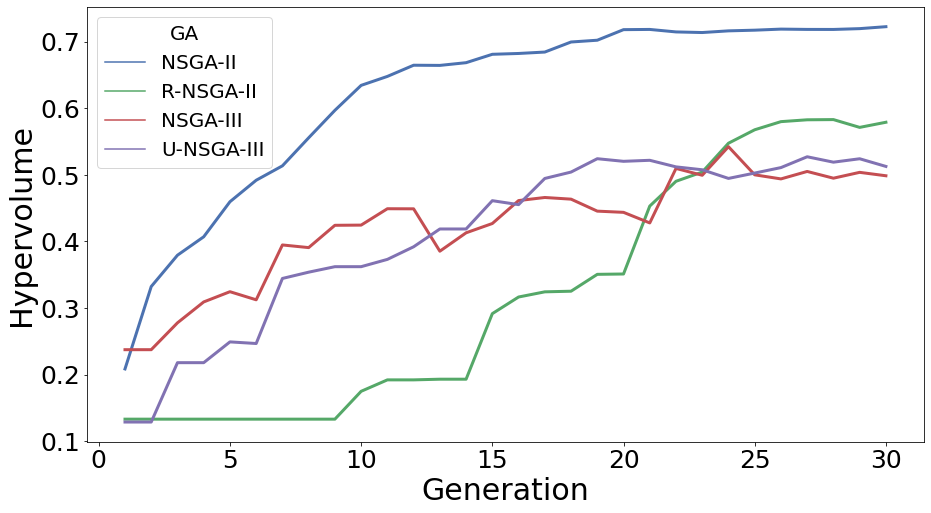

In [39]:
plt.figure(figsize=(15,8))
sns.lineplot(data=results_summary_df, x ='Generation', y='HV - Average', hue='GA', linewidth=3)
plt.legend(title='GA', fontsize=20, title_fontsize=20)
plt.xlabel('Generation', fontsize=30);
plt.xticks(fontsize=25)
plt.ylabel('Hypervolume', fontsize=30);
plt.yticks(fontsize=25)
plt.savefig('GAs.pdf')
plt.show()

In [40]:
NSGA2_data = []
RNSGA2_data = []
NSGA3_data = []
UNSGA3_data = []

length_of_arr = len(NSGA2_HV[0])

for i in range(length_of_arr):
    NSGA2_data.append(['NSGA-II', i+1, NSGA2_HV[0][i], NSGA2_HV[1][i], NSGA2_HV[2][i], NSGA2_HV[3][i], NSGA2_HV[4][i],
                 NSGA2_HV[5][i], NSGA2_HV[6][i], NSGA2_HV[7][i], NSGA2_HV[8][i], NSGA2_HV[9][i]])
    NSGA2_data.append(['SA_NSGA-II', i+1, SA_NSGA2_HV[0][i], SA_NSGA2_HV[1][i], SA_NSGA2_HV[2][i], SA_NSGA2_HV[3][i], SA_NSGA2_HV[4][i],
                 SA_NSGA2_HV[5][i], SA_NSGA2_HV[6][i], SA_NSGA2_HV[7][i], SA_NSGA2_HV[8][i], SA_NSGA2_HV[9][i]])
        
    RNSGA2_data.append(['R-NSGA-II', i+1, RNSGA2_HV[0][i], RNSGA2_HV[1][i], RNSGA2_HV[2][i], RNSGA2_HV[3][i], 
                 RNSGA2_HV[4][i], RNSGA2_HV[5][i], RNSGA2_HV[6][i], RNSGA2_HV[7][i], RNSGA2_HV[8][i], RNSGA2_HV[9][i]])
    RNSGA2_data.append(['SA_R-NSGA-II', i+1, SA_RNSGA2_HV[0][i], SA_RNSGA2_HV[1][i], SA_RNSGA2_HV[2][i], SA_RNSGA2_HV[3][i], 
                 SA_RNSGA2_HV[4][i], SA_RNSGA2_HV[5][i], SA_RNSGA2_HV[6][i], SA_RNSGA2_HV[7][i], SA_RNSGA2_HV[8][i], SA_RNSGA2_HV[9][i]])
    
    NSGA3_data.append(['NSGA-III', i+1, NSGA3_HV[0][i], NSGA3_HV[1][i], NSGA3_HV[1][i], NSGA3_HV[3][i], NSGA3_HV[4][i],
                 NSGA3_HV[5][i], NSGA3_HV[6][i], NSGA3_HV[7][i], NSGA3_HV[8][i], NSGA3_HV[9][i]])
    NSGA3_data.append(['SA_NSGA-III', i+1, SA_NSGA3_HV[0][i], SA_NSGA3_HV[1][i], SA_NSGA3_HV[1][i], SA_NSGA3_HV[3][i], SA_NSGA3_HV[4][i],
                 SA_NSGA3_HV[5][i], SA_NSGA3_HV[6][i], SA_NSGA3_HV[7][i], SA_NSGA3_HV[8][i], SA_NSGA3_HV[9][i]])
    
    UNSGA3_data.append(['U-NSGA-III', i+1, UNSGA3_HV[0][i], UNSGA3_HV[1][i], UNSGA3_HV[2][i], UNSGA3_HV[3][i], 
                 UNSGA3_HV[4][i], UNSGA3_HV[5][i], UNSGA3_HV[6][i], UNSGA3_HV[7][i], UNSGA3_HV[8][i], UNSGA3_HV[9][i]])
    UNSGA3_data.append(['SA_U-NSGA-III', i+1, SA_UNSGA3_HV[0][i], SA_UNSGA3_HV[1][i], SA_UNSGA3_HV[2][i], SA_UNSGA3_HV[3][i], 
                 SA_UNSGA3_HV[4][i], SA_UNSGA3_HV[5][i], SA_UNSGA3_HV[6][i], SA_UNSGA3_HV[7][i], SA_UNSGA3_HV[8][i], SA_UNSGA3_HV[9][i]])

  
# Creating a new dataframe:
NSGA2_results_summary = pd.DataFrame(NSGA2_data, columns=['GA', 'Generation', 'HV - Run 1', 'HV - Run 2', 'HV - Run 3', 
                                              'HV - Run 4', 'HV - Run 5', 'HV - Run 6', 'HV - Run 7', 'HV - Run 8', 
                                              'HV - Run 9', 'HV - Run 10'])
RNSGA2_results_summary = pd.DataFrame(RNSGA2_data, columns=['GA', 'Generation', 'HV - Run 1', 'HV - Run 2', 'HV - Run 3', 
                                              'HV - Run 4', 'HV - Run 5', 'HV - Run 6', 'HV - Run 7', 'HV - Run 8', 
                                              'HV - Run 9', 'HV - Run 10'])
NSGA3_results_summary = pd.DataFrame(NSGA3_data, columns=['GA', 'Generation', 'HV - Run 1', 'HV - Run 2', 'HV - Run 3', 
                                              'HV - Run 4', 'HV - Run 5', 'HV - Run 6', 'HV - Run 7', 'HV - Run 8', 
                                              'HV - Run 9', 'HV - Run 10'])
UNSGA3_results_summary = pd.DataFrame(UNSGA3_data, columns=['GA', 'Generation', 'HV - Run 1', 'HV - Run 2', 'HV - Run 3', 
                                              'HV - Run 4', 'HV - Run 5', 'HV - Run 6', 'HV - Run 7', 'HV - Run 8', 
                                              'HV - Run 9', 'HV - Run 10'])

# Converting from object to integer types:
NSGA2_results_summary[['HV - Run 1', 'HV - Run 2', 'HV - Run 3', 'HV - Run 4', 'HV - Run 5', 'HV - Run 6', 
                 'HV - Run 7', 'HV - Run 8', 'HV - Run 9', 'HV - Run 10']].astype(int)
RNSGA2_results_summary[['HV - Run 1', 'HV - Run 2', 'HV - Run 3', 'HV - Run 4', 'HV - Run 5', 'HV - Run 6', 
                 'HV - Run 7', 'HV - Run 8', 'HV - Run 9', 'HV - Run 10']].astype(int)
NSGA3_results_summary[['HV - Run 1', 'HV - Run 2', 'HV - Run 3', 'HV - Run 4', 'HV - Run 5', 'HV - Run 6', 
                 'HV - Run 7', 'HV - Run 8', 'HV - Run 9', 'HV - Run 10']].astype(int)
UNSGA3_results_summary[['HV - Run 1', 'HV - Run 2', 'HV - Run 3', 'HV - Run 4', 'HV - Run 5', 'HV - Run 6', 
                 'HV - Run 7', 'HV - Run 8', 'HV - Run 9', 'HV - Run 10']].astype(int)

NSGA2_results_summary[['HV - Run 1', 'HV - Run 2', 'HV - Run 3', 'HV - Run 4', 'HV - Run 5', 'HV - Run 6', 
                 'HV - Run 7', 'HV - Run 8', 'HV - Run 9', 'HV - Run 10']] = NSGA2_results_summary[['HV - Run 1', 
                    'HV - Run 2', 'HV - Run 3', 'HV - Run 4', 'HV - Run 5', 'HV - Run 6', 
                 'HV - Run 7', 'HV - Run 8', 'HV - Run 9', 'HV - Run 10']].replace("0.0", "[0.0]", 
                                                                                    regex = True).astype("float")
RNSGA2_results_summary[['HV - Run 1', 'HV - Run 2', 'HV - Run 3', 'HV - Run 4', 'HV - Run 5', 'HV - Run 6', 
                 'HV - Run 7', 'HV - Run 8', 'HV - Run 9', 'HV - Run 10']] = RNSGA2_results_summary[['HV - Run 1',
                    'HV - Run 2', 'HV - Run 3', 'HV - Run 4', 'HV - Run 5', 'HV - Run 6', 
                 'HV - Run 7', 'HV - Run 8', 'HV - Run 9', 'HV - Run 10']].replace("0.0", "[0.0]", 
                                                                                    regex = True).astype("float")
NSGA3_results_summary[['HV - Run 1', 'HV - Run 2', 'HV - Run 3', 'HV - Run 4', 'HV - Run 5', 'HV - Run 6', 
                 'HV - Run 7', 'HV - Run 8', 'HV - Run 9', 'HV - Run 10']] = NSGA3_results_summary[['HV - Run 1',
                    'HV - Run 2', 'HV - Run 3', 'HV - Run 4', 'HV - Run 5', 'HV - Run 6', 
                 'HV - Run 7', 'HV - Run 8', 'HV - Run 9', 'HV - Run 10']].replace("0.0", "[0.0]", 
                                                                                    regex = True).astype("float")
UNSGA3_results_summary[['HV - Run 1', 'HV - Run 2', 'HV - Run 3', 'HV - Run 4', 'HV - Run 5', 'HV - Run 6', 
                 'HV - Run 7', 'HV - Run 8', 'HV - Run 9', 'HV - Run 10']] = UNSGA3_results_summary[['HV - Run 1',
                    'HV - Run 2', 'HV - Run 3', 'HV - Run 4', 'HV - Run 5', 'HV - Run 6', 
                 'HV - Run 7', 'HV - Run 8', 'HV - Run 9', 'HV - Run 10']].replace("0.0", "[0.0]", 
                                                                                    regex = True).astype("float")

NSGA2_results_summary.head()
# RNSGA2_results_summary
# NSGA3_results_summary
# UNSGA3_results_summary

,GA,Generation,HV - Run 1,HV - Run 2,HV - Run 3,HV - Run 4,HV - Run 5,HV - Run 6,HV - Run 7,HV - Run 8,HV - Run 9,HV - Run 10
0,NSGA-II,1,0.105704,0.02247,0.376528,0.299773,0.116155,0.000000,0.373526,0.375101,0.299773,0.116155
1,SA_NSGA-II,1,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,NSGA-II,2,0.105704,0.38992,0.376528,0.359217,0.430995,0.000000,0.373526,0.496399,0.359217,0.430995
3,SA_NSGA-II,2,0.000000,0.00000,0.000000,0.000000,0.042866,0.071194,0.073614,0.052231,0.015044,0.309597
4,NSGA-II,3,0.369303,0.38992,0.391263,0.379137,0.462701,0.000000,0.457838,0.500997,0.379137,0.462701


In [41]:
NSGA2_results_summary_df = NSGA2_results_summary.copy()
NSGA2_results_summary_df['HV - Average'] = NSGA2_results_summary_df[['HV - Run 1', 'HV - Run 2', 'HV - Run 3', 'HV - Run 4', 
                                                         'HV - Run 5', 'HV - Run 6', 'HV - Run 7', 'HV - Run 8', 
                                                         'HV - Run 9', 'HV - Run 10']].mean(axis=1)

RNSGA2_results_summary_df = RNSGA2_results_summary.copy()
RNSGA2_results_summary_df['HV - Average'] = RNSGA2_results_summary_df[['HV - Run 1', 'HV - Run 2', 'HV - Run 3', 'HV - Run 4', 
                                                         'HV - Run 5', 'HV - Run 6', 'HV - Run 7', 'HV - Run 8', 
                                                         'HV - Run 9', 'HV - Run 10']].mean(axis=1)

NSGA3_results_summary_df = NSGA3_results_summary.copy()
NSGA3_results_summary_df['HV - Average'] = NSGA3_results_summary_df[['HV - Run 1', 'HV - Run 2', 'HV - Run 3', 'HV - Run 4', 
                                                         'HV - Run 5', 'HV - Run 6', 'HV - Run 7', 'HV - Run 8', 
                                                         'HV - Run 9', 'HV - Run 10']].mean(axis=1)

UNSGA3_results_summary_df = UNSGA3_results_summary.copy()
UNSGA3_results_summary_df['HV - Average'] = UNSGA3_results_summary_df[['HV - Run 1', 'HV - Run 2', 'HV - Run 3', 'HV - Run 4', 
                                                         'HV - Run 5', 'HV - Run 6', 'HV - Run 7', 'HV - Run 8', 
                                                         'HV - Run 9', 'HV - Run 10']].mean(axis=1)
NSGA2_results_summary_df.tail()

,GA,Generation,HV - Run 1,HV - Run 2,HV - Run 3,HV - Run 4,HV - Run 5,HV - Run 6,HV - Run 7,HV - Run 8,HV - Run 9,HV - Run 10,HV - Average
55,SA_NSGA-II,28,0.707931,0.761271,0.746751,0.749727,0.756800,0.759001,0.768934,0.753513,0.761133,0.759229,0.752429
56,NSGA-II,29,0.708185,0.713112,0.729268,0.727653,0.712153,0.715692,0.728713,0.720898,0.727653,0.712153,0.719548
57,SA_NSGA-II,29,0.708215,0.761458,0.746920,0.751570,0.758291,0.762140,0.770158,0.753645,0.761294,0.759719,0.753341
58,NSGA-II,30,0.708185,0.714721,0.729268,0.732852,0.713305,0.730731,0.728632,0.720898,0.732852,0.713305,0.722475
59,SA_NSGA-II,30,0.715734,0.761461,0.747659,0.751825,0.758428,0.762692,0.770178,0.754094,0.761294,0.759782,0.754315


In [42]:
RNSGA2_results_summary_df.tail()

,GA,Generation,HV - Run 1,HV - Run 2,HV - Run 3,HV - Run 4,HV - Run 5,HV - Run 6,HV - Run 7,HV - Run 8,HV - Run 9,HV - Run 10,HV - Average
55,SA_R-NSGA-II,28,0.726223,0.745010,0.641089,0.719613,0.755778,0.714731,0.690498,0.760136,0.694250,0.727979,0.717531
56,R-NSGA-II,29,1.331000,0.553637,0.437403,0.455084,0.490694,0.507905,0.553637,0.437403,0.455084,0.490694,0.571254
57,SA_R-NSGA-II,29,0.726223,0.747902,0.641091,0.719613,0.755778,0.714731,0.690561,0.760136,0.694250,0.727981,0.717827
58,R-NSGA-II,30,1.331000,0.570067,0.442310,0.455298,0.494014,0.535181,0.570067,0.442310,0.455298,0.494014,0.578956
59,SA_R-NSGA-II,30,0.726223,0.747902,0.641124,0.719613,0.755812,0.716397,0.690561,0.761098,0.694250,0.727981,0.718096


In [43]:
NSGA3_results_summary_df.tail()

,GA,Generation,HV - Run 1,HV - Run 2,HV - Run 3,HV - Run 4,HV - Run 5,HV - Run 6,HV - Run 7,HV - Run 8,HV - Run 9,HV - Run 10,HV - Average
55,SA_NSGA-III,28,0.649292,0.564636,0.564636,0.692202,0.664858,0.689519,0.653479,0.648448,0.639033,0.611343,0.637745
56,NSGA-III,29,0.451219,0.458876,0.458876,0.490343,0.613238,0.484819,0.458876,0.517510,0.490343,0.613238,0.503734
57,SA_NSGA-III,29,0.649292,0.564636,0.564636,0.692202,0.668760,0.701873,0.653479,0.657624,0.639033,0.611343,0.640288
58,NSGA-III,30,0.451219,0.458876,0.458876,0.490343,0.613238,0.484819,0.458876,0.466174,0.490343,0.613238,0.498600
59,SA_NSGA-III,30,0.649292,0.564636,0.564636,0.692202,0.668760,0.701873,0.653479,0.657624,0.639033,0.611343,0.640288


In [44]:
UNSGA3_results_summary_df.tail()

,GA,Generation,HV - Run 1,HV - Run 2,HV - Run 3,HV - Run 4,HV - Run 5,HV - Run 6,HV - Run 7,HV - Run 8,HV - Run 9,HV - Run 10,HV - Average
55,SA_U-NSGA-III,28,0.721845,0.725471,0.662446,0.698128,0.744762,0.717161,0.729404,0.654690,0.721969,0.697449,0.707332
56,U-NSGA-III,29,0.500200,0.473577,0.548882,0.664630,0.475832,0.415419,0.473577,0.548882,0.664630,0.475832,0.524146
57,SA_U-NSGA-III,29,0.728370,0.725471,0.662446,0.698128,0.744762,0.724026,0.729404,0.654690,0.727306,0.697449,0.709205
58,U-NSGA-III,30,0.498220,0.486277,0.512417,0.597858,0.475991,0.483075,0.486277,0.512417,0.597858,0.475991,0.512638
59,SA_U-NSGA-III,30,0.728370,0.725471,0.663178,0.698534,0.744762,0.724026,0.729404,0.654690,0.727306,0.697677,0.709342


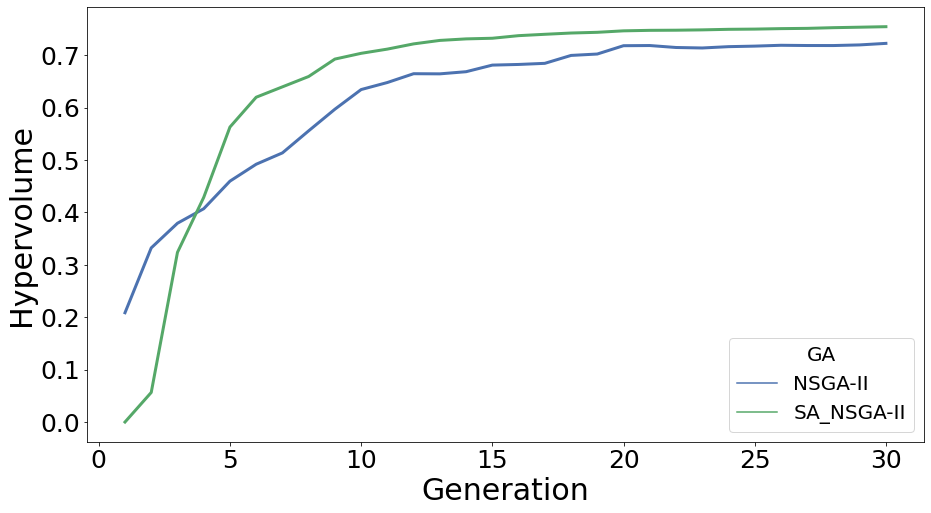

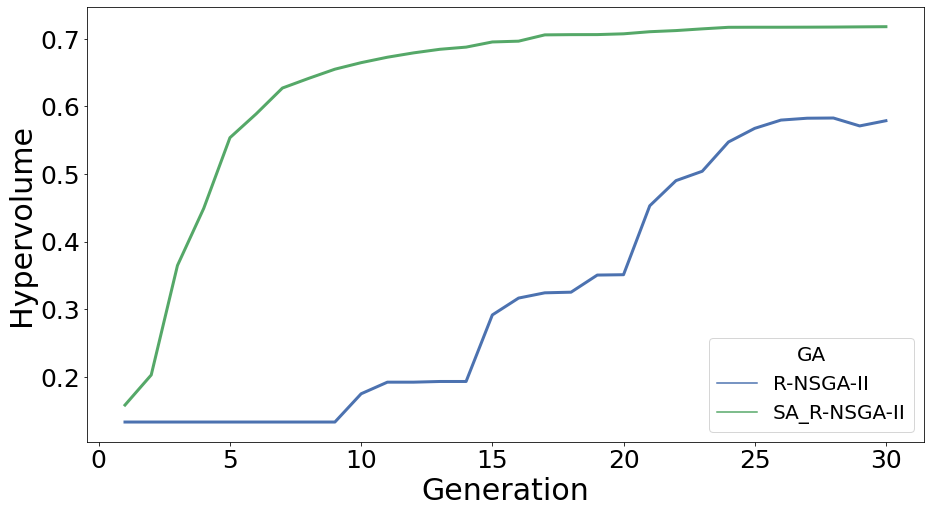

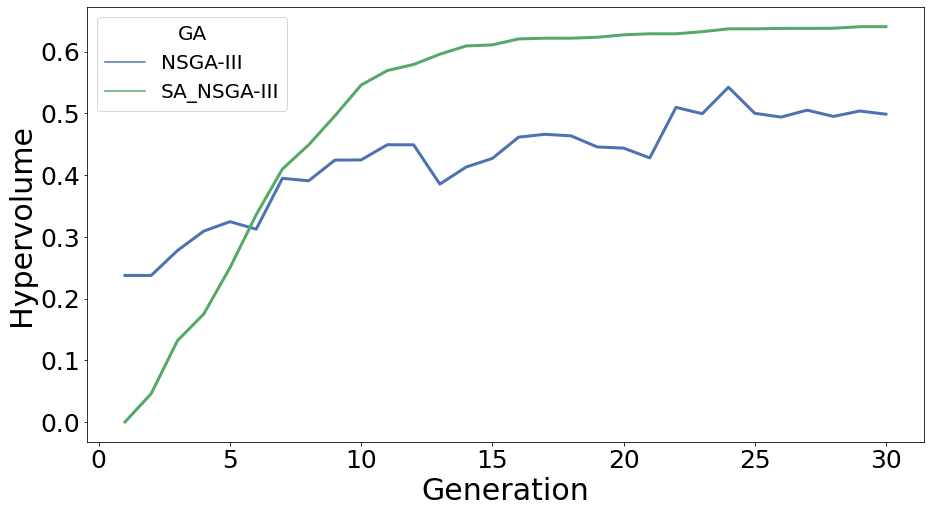

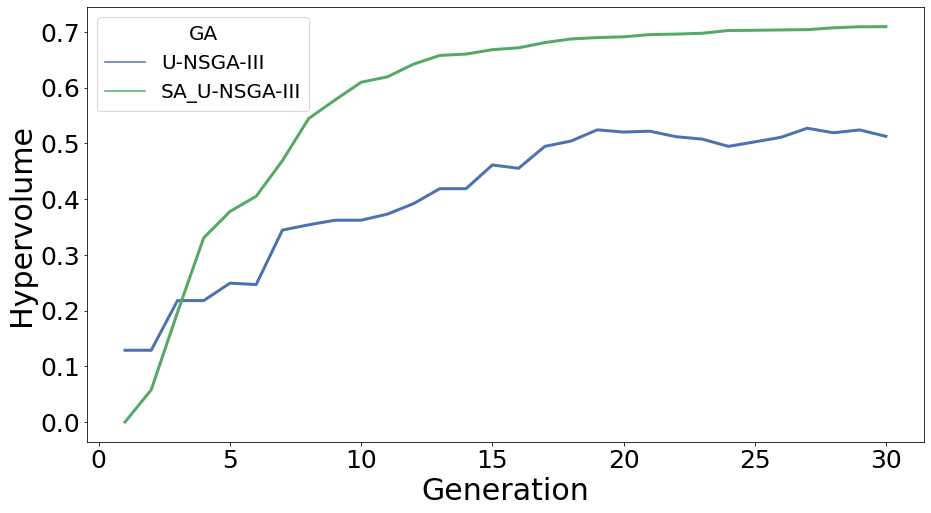

In [45]:
def Plot_Comparisons(data, file_name):
    plt.figure(figsize=(15,8))
    sns.lineplot(data=data, x ='Generation', y='HV - Average', hue='GA', linewidth=3)
    plt.legend(title='GA', fontsize=20, title_fontsize=20)
    plt.xlabel('Generation', fontsize=30);
    plt.xticks(fontsize=25)
    plt.ylabel('Hypervolume', fontsize=30);
    plt.yticks(fontsize=25)
    plt.savefig('{}.pdf'.format(file_name))
    plt.show()

Plot_Comparisons(NSGA2_results_summary_df, "NSGA-II")
Plot_Comparisons(RNSGA2_results_summary_df, "R-NSGA-II")
Plot_Comparisons(NSGA3_results_summary_df, "NSGA-III")
Plot_Comparisons(UNSGA3_results_summary_df, "U-NSGA-III")

## Backtesting:

In [46]:
run = 0

# Generating the weights for each asset:
print("Surrogate Assisted NSGA-II - Generations: 30, Population: 12")
NSGA_II_weights1, weight_result1, time1 = NSGA2_Algorithm(12, 30, 'weight', 'surrogate', run)

print("Surrogate Assisted R-NSGA-II - Generations: 30, Population: 12")
R_NSGA_II_weights1, weight_result2, time2 = R_NSGA2_Algorithm(12, 30, 'weight', 'surrogate', run)

print("Surrogate Assisted NSGA-III - Generations: 30, Population: 12")
NSGA_III_weights1, weight_result3, time3 = NSGA3_Algorithm(12, 30, 'weight', 'surrogate', run)

print("Surrogate Assisted U-NSGA-III - Generations: 30, Population: 12")
U_NSGA_III_weights1, weight_result4, time4 = U_NSGA3_Algorithm(12, 30, 'weight', 'surrogate', run)

Surrogate Assisted NSGA-II - Generations: 30, Population: 12
n_gen |  n_eval |  n_nds  |     eps      |  indicator   | n_influenced
    2 |       3 |       3 |            - |            - |            -
    3 |       5 |       5 |  0.274821638 |            f |          2/2
    4 |       7 |       7 |  0.055663686 |        ideal |          1/2
    5 |       9 |       9 |  0.603688185 |        ideal |          2/2
    6 |      11 |      11 |  0.030624694 |            f |          2/2
    7 |      13 |      12 |  0.093608362 |        nadir |          2/2
    8 |      15 |      12 |  0.016538863 |        nadir |          1/2
    9 |      17 |      12 |  0.025693967 |        ideal |          1/2
   10 |      19 |      12 |  0.003841692 |            f |          1/2
   11 |      21 |      12 |  0.015154307 |            f |          2/2
   12 |      23 |      12 |  0.00000E+00 |            f |          2/2
   13 |      25 |      12 |  0.026932017 |            f |          1/2
   14 |      27 

    8 |      15 |       2 |  0.00000E+00 |            f |          2/2
    9 |      17 |       2 |  0.040210176 |        ideal |          1/2
   10 |      19 |       2 |  0.388051627 |        ideal |          1/2
   11 |      21 |       2 |  0.00000E+00 |            f |          1/2
   12 |      23 |       3 |  0.348587542 |        ideal |          1/2
   13 |      25 |       3 |  0.00000E+00 |            f |          2/2
   14 |      27 |       3 |  0.048494739 |        ideal |          2/2
   15 |      29 |       2 |  0.00000E+00 |            f |          2/2
   16 |      31 |       2 |  0.426564396 |        ideal |          2/2
   17 |      33 |       2 |  0.00000E+00 |            f |          2/2
   18 |      35 |       2 |  0.00000E+00 |            f |          1/2
   19 |      37 |       2 |  0.00000E+00 |            f |          2/2
   20 |      39 |       3 |  0.103009929 |            f |          2/2
   21 |      41 |       3 |  0.00000E+00 |            f |          2/2
   22 

In [47]:
# The optimal set of weights for the surrogate-assisted NSGA-II are:
weight_result1.F[0]

array([0.10909241, 0.11046037, 0.0996048 , 0.10098925, 0.08643999,
       0.09859767, 0.11365604, 0.0921176 , 0.11187223, 0.07716963])

In [48]:
def Sum_of_Weights(result):
    stocks = listing[:10]

    weight_list = result.F[0]

    dictionary = dict(zip(stocks, weight_list))
    
    list = []
    for i in dictionary:
        list.append(dictionary[i])
    total = sum(list)

    while total != 1:
        if(total < 1):
            diff = 1 - total
            list[9] = list[9] + diff

        if(total > 1):
            diff = total - 1
            list[9] = list[9] - diff

        total = sum(list)
    print("Sum of all weights: ", total)
    
    # Creating a dictionary that maps stocks to weights:
    backtest_array = dict(zip(stocks, list))
    print(backtest_array)
    return backtest_array

print("................................. Backtest: NSGA-II .................................")
NSGA2_Backtest = Sum_of_Weights(weight_result1)
print("\n")
    
print("................................. Backtest: R-NSGA-II .................................")
RNSGA2_Backtest = Sum_of_Weights(weight_result2)
print("\n")

print("................................. Backtest: NSGA-III .................................")
NSGA3_Backtest = Sum_of_Weights(weight_result3)
print("\n")

print("................................. Backtest: U-NSGA-III .................................")
UNSGA3_Backtest = Sum_of_Weights(weight_result4)

................................. Backtest: NSGA-II .................................
Sum of all weights:  1.0
{'NVDA': 0.1090924057233688, 'NFLX': 0.110460371744453, 'ALGN': 0.0996047969707605, 'EA': 0.1009892492081403, 'STZ': 0.0864399944055433, 'AVGO': 0.098597670680188, 'MU': 0.1136560431112081, 'AMZN': 0.0921176018524137, 'ATVI': 0.1118722319996395, 'HII': 0.0771696343042848}


................................. Backtest: R-NSGA-II .................................
Sum of all weights:  1.0
{'NVDA': 0.1083791071639725, 'NFLX': 0.1089265793319713, 'ALGN': 0.0997562273027927, 'EA': 0.1009487381576005, 'STZ': 0.0889494599178264, 'AVGO': 0.0973475203302114, 'MU': 0.1114608959770414, 'AMZN': 0.0921566441302418, 'ATVI': 0.1127274727194209, 'HII': 0.079347354968921}


................................. Backtest: NSGA-III .................................
Sum of all weights:  1.0
{'NVDA': 0.1127767157692608, 'NFLX': 0.1183763656667102, 'ALGN': 0.097969330866298, 'EA': 0.099836887816909, 'STZ

In [49]:
# Backtesting without using any genetic algorithms to find the weight of each asset:
stocks = listing[:10]
Backtest(tickers=stocks).run()

[{'portfolio': 'Tangency Portfolio',
  'tickers': {'ALGN': 0.0,
   'AMZN': 0.10402,
   'ATVI': 0.07502,
   'AVGO': 0.1768,
   'EA': 0.0,
   'HII': 0.16199,
   'MU': 0.0,
   'NFLX': 0.0,
   'NVDA': 0.1542,
   'STZ': 0.32796},
  'Expected annual return': '26.6%',
  'Annual volatility': '22.4%',
  'Sharpe Ratio': '1.10',
  'Conditional Value at Risk': '',
  'Cumulative Return': '2093.9%'},
 {'portfolio': 'Minimum Variance Portfolio',
  'tickers': {'ALGN': 0.0,
   'AMZN': 0.12236,
   'ATVI': 0.17056,
   'AVGO': 0.03708,
   'EA': 0.09973,
   'HII': 0.32812,
   'MU': 0.0,
   'NFLX': 0.00968,
   'NVDA': 0.0,
   'STZ': 0.23248},
  'Expected annual return': '21.4%',
  'Annual volatility': '19.7%',
  'Sharpe Ratio': '0.98',
  'Conditional Value at Risk': '',
  'Cumulative Return': '1200.9%'},
 {'portfolio': 'Hierarchical Risk Parity Portfolio',
  'tickers': {'ALGN': 0.05111,
   'AMZN': 0.11989,
   'ATVI': 0.13692,
   'AVGO': 0.08824,
   'EA': 0.09803,
   'HII': 0.21203,
   'MU': 0.03135,
   'NFL

In [50]:
# Backtesting the portfolio by using GAs to find the weights of each asset:

# NSGA-II:
back_test1 = Backtest(
    tickers=NSGA2_Backtest,

    target_return=0.1,
    target_cvar=0.025,
    data_dir="NSGA2_Backtest",
    start="2013-02-08",
    end="2018-02-07",
)
pprint.pprint(back_test1.run(plot=True))

[*********************100%***********************]  10 of 10 completed
[{'Annual volatility': '19.4%',
  'Conditional Value at Risk': '',
  'Cumulative Return': '822.1%',
  'Expected annual return': '50.8%',
  'Sharpe Ratio': '2.52',
  'portfolio': 'Your Portfolio',
  'tickers': {'ALGN': 0.0996,
              'AMZN': 0.09212,
              'ATVI': 0.11187,
              'AVGO': 0.0986,
              'EA': 0.10099,
              'HII': 0.07717,
              'MU': 0.11366,
              'NFLX': 0.11046,
              'NVDA': 0.10909,
              'STZ': 0.08644}},
 {'Annual volatility': '18.2%',
  'Conditional Value at Risk': '',
  'Cumulative Return': '924.8%',
  'Expected annual return': '55.6%',
  'Sharpe Ratio': '2.94',
  'portfolio': 'Tangency Portfolio',
  'tickers': {'ALGN': 0.08847,
              'AMZN': 0.03605,
              'ATVI': 0.01041,
              'AVGO': 0.0,
              'EA': 0.10048,
              'HII': 0.20448,
              'MU': 0.0,
              'NFLX': 0.0

In [51]:
# R-NSGA-II:
back_test2 = Backtest(
    tickers=RNSGA2_Backtest,

    target_return=0.1,
    target_cvar=0.025,
    data_dir="RNSGA2_Backtest",
    start="2013-02-08",
    end="2018-02-07",
)
pprint.pprint(back_test2.run(plot=True))

[*********************100%***********************]  10 of 10 completed
[{'Annual volatility': '19.3%',
  'Conditional Value at Risk': '',
  'Cumulative Return': '820.0%',
  'Expected annual return': '50.8%',
  'Sharpe Ratio': '2.53',
  'portfolio': 'Your Portfolio',
  'tickers': {'ALGN': 0.09976,
              'AMZN': 0.09216,
              'ATVI': 0.11273,
              'AVGO': 0.09735,
              'EA': 0.10095,
              'HII': 0.07935,
              'MU': 0.11146,
              'NFLX': 0.10893,
              'NVDA': 0.10838,
              'STZ': 0.08895}},
 {'Annual volatility': '18.2%',
  'Conditional Value at Risk': '',
  'Cumulative Return': '924.8%',
  'Expected annual return': '55.6%',
  'Sharpe Ratio': '2.94',
  'portfolio': 'Tangency Portfolio',
  'tickers': {'ALGN': 0.08847,
              'AMZN': 0.03605,
              'ATVI': 0.01041,
              'AVGO': 0.0,
              'EA': 0.10048,
              'HII': 0.20448,
              'MU': 0.0,
              'NFLX': 0

In [52]:
# NSGA-III:
back_test3 = Backtest(
    tickers=NSGA3_Backtest, 

    target_return=0.1,
    target_cvar=0.025,
    data_dir="NSGA3_Backtest",
    start="2013-02-08",
    end="2018-02-07",
)
pprint.pprint(back_test3.run(plot=True))

[*********************100%***********************]  10 of 10 completed
[{'Annual volatility': '19.7%',
  'Conditional Value at Risk': '',
  'Cumulative Return': '832.1%',
  'Expected annual return': '51.1%',
  'Sharpe Ratio': '2.49',
  'portfolio': 'Your Portfolio',
  'tickers': {'ALGN': 0.09797,
              'AMZN': 0.09123,
              'ATVI': 0.10693,
              'AVGO': 0.10417,
              'EA': 0.09984,
              'HII': 0.06829,
              'MU': 0.12576,
              'NFLX': 0.11838,
              'NVDA': 0.11278,
              'STZ': 0.07466}},
 {'Annual volatility': '18.2%',
  'Conditional Value at Risk': '',
  'Cumulative Return': '924.8%',
  'Expected annual return': '55.6%',
  'Sharpe Ratio': '2.94',
  'portfolio': 'Tangency Portfolio',
  'tickers': {'ALGN': 0.08847,
              'AMZN': 0.03605,
              'ATVI': 0.01041,
              'AVGO': 0.0,
              'EA': 0.10048,
              'HII': 0.20448,
              'MU': 0.0,
              'NFLX': 0

In [53]:
# U-NSGA-III:
back_test4 = Backtest(
    tickers=UNSGA3_Backtest, 

    target_return=0.1,
    target_cvar=0.025,
    data_dir="UNSGA3_Backtest",
    start="2013-02-08",
    end="2018-02-07",
)
pprint.pprint(back_test4.run(plot=True))

[*********************100%***********************]  10 of 10 completed
[{'Annual volatility': '19.7%',
  'Conditional Value at Risk': '',
  'Cumulative Return': '830.9%',
  'Expected annual return': '51.0%',
  'Sharpe Ratio': '2.49',
  'portfolio': 'Your Portfolio',
  'tickers': {'ALGN': 0.09822,
              'AMZN': 0.09139,
              'ATVI': 0.10755,
              'AVGO': 0.10359,
              'EA': 0.10008,
              'HII': 0.06915,
              'MU': 0.12429,
              'NFLX': 0.11746,
              'NVDA': 0.11235,
              'STZ': 0.07592}},
 {'Annual volatility': '18.2%',
  'Conditional Value at Risk': '',
  'Cumulative Return': '924.8%',
  'Expected annual return': '55.6%',
  'Sharpe Ratio': '2.94',
  'portfolio': 'Tangency Portfolio',
  'tickers': {'ALGN': 0.08847,
              'AMZN': 0.03605,
              'ATVI': 0.01041,
              'AVGO': 0.0,
              'EA': 0.10048,
              'HII': 0.20448,
              'MU': 0.0,
              'NFLX': 0